thanks to EDA https://www.kaggle.com/code/endofnight17j03/abalone-age-ann-xgboost-catboost

## Importing Libraries

In [1]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,VotingRegressor,HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score,r2_score,recall_score,roc_auc_score,confusion_matrix,classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
import optuna
import keras_tuner
import kerastuner
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.exceptions import DataConversionWarning
from catboost import CatBoostRegressor,Pool
from catboost.utils import eval_metric
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import ttest_ind,chi2_contingency
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight

import pandas as pd 
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install ipywidgets -q
!pip install "flaml[automl]" -q


2024-05-07 20:58:07.511262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 20:58:07.511427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 20:58:07.692130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_18/2106270868.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


## Setting for Visualization

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')


## Reading train and test data

In [3]:
pd.set_option("display.max_columns", 500)
DATA_PATH  = '/kaggle/input/playground-series-s4e5/'
Flood_DATA_PATH = '/kaggle/input/flood-prediction-factors/'

train = pd.read_csv(f'{DATA_PATH}train.csv', index_col='id')
test = pd.read_csv(f'{DATA_PATH}test.csv', index_col='id')
train_flood = pd.read_csv(f'{Flood_DATA_PATH}flood.csv')
initial_features = list(test.columns)
print(f"The initial features are: {initial_features}")

The initial features are: ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']


In [4]:
print(f"The shape of train data: {train.shape}")
print(f"The shape of test data: {test.shape}")
print(f"The shape of flood prediction factor train data: {train_flood.shape}")

The shape of train data: (1117957, 21)
The shape of test data: (745305, 20)
The shape of flood prediction factor train data: (50000, 21)


In [5]:
full_data = pd.concat([train, train_flood], axis=0)
full_data.sample(5).style.background_gradient()

In [6]:
train.sample(5).style.background_gradient()

In [7]:
train_flood.sample(5).style.background_gradient()

In [8]:
test.sample(5).style.background_gradient()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

In [10]:
train_flood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

### All train, flood_train, test data does not contain null values

## Statistical information 

In [11]:
train.describe().T.style.background_gradient()

In [12]:
train_flood.describe().T.style.background_gradient()

In [13]:
test.describe().T.style.background_gradient()

## check for duplicated values

In [14]:
train.duplicated().sum()

0

In [15]:
train_flood.duplicated().sum()

0

In [16]:
test.duplicated().sum()

0

### There are no duplicated data in train, flood_train and test data

### Target column visualization

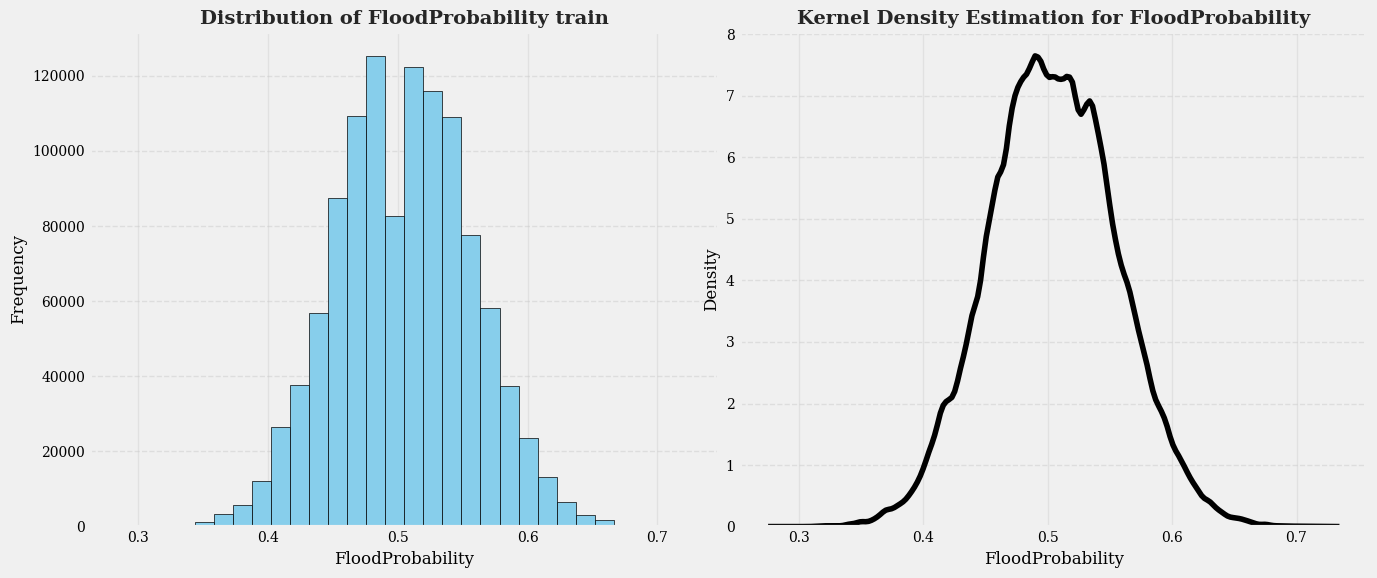

In [17]:
plt.figure(figsize=(14, 6))

# plotting histogram and KDE plot for "FloodProbability" column for train_data
plt.subplot(1, 2, 1)
plt.hist(train['FloodProbability'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of FloodProbability train', fontsize=14, fontweight='bold')
plt.xlabel('FloodProbability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# plotting KDE for 'FloodProbability' column
plt.subplot(1, 2, 2)
sns.kdeplot(train['FloodProbability'], color='black')
plt.title('Kernel Density Estimation for FloodProbability', fontsize=14,\
         fontweight='bold')
plt.xlabel('FloodProbability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

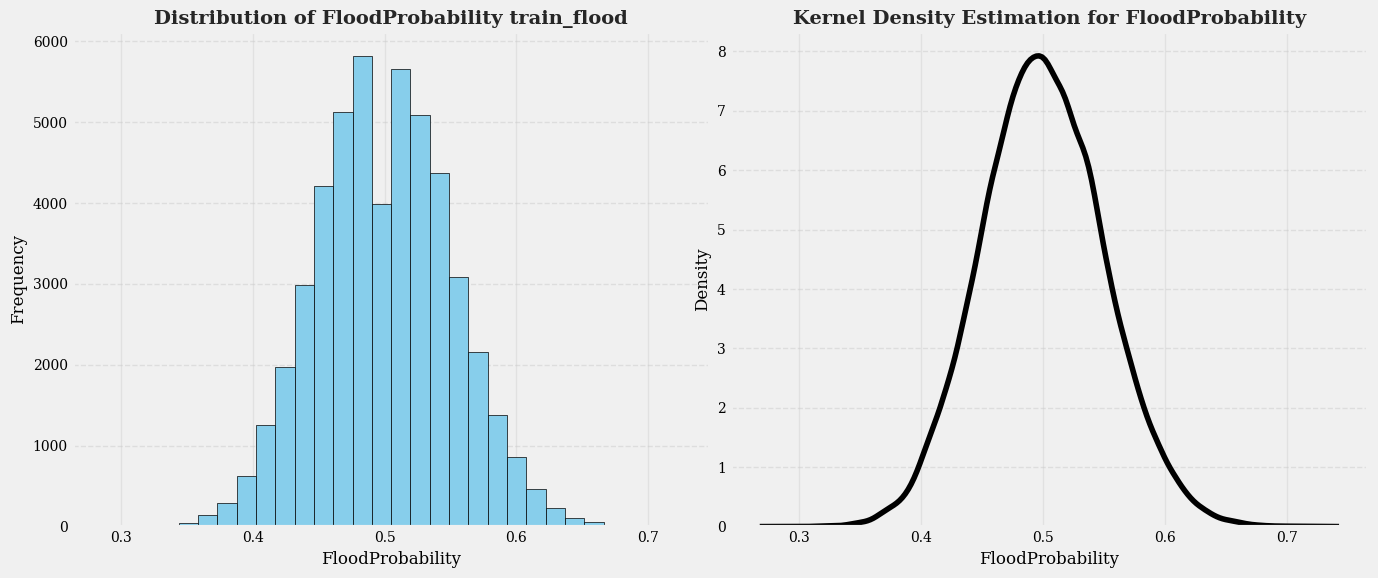

In [18]:
plt.figure(figsize=(14, 6))

# plotting histogram and KDE plot for "FloodProbability" column for train_flood data
plt.subplot(1, 2, 1)
plt.hist(train_flood['FloodProbability'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of FloodProbability train_flood', fontsize=14, fontweight='bold')
plt.xlabel('FloodProbability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# plotting KDE for 'FloodProbability' column
plt.subplot(1, 2, 2)
sns.kdeplot(train_flood['FloodProbability'], color='black')
plt.title('Kernel Density Estimation for FloodProbability', fontsize=14,\
         fontweight='bold')
plt.xlabel('FloodProbability', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Features visualization

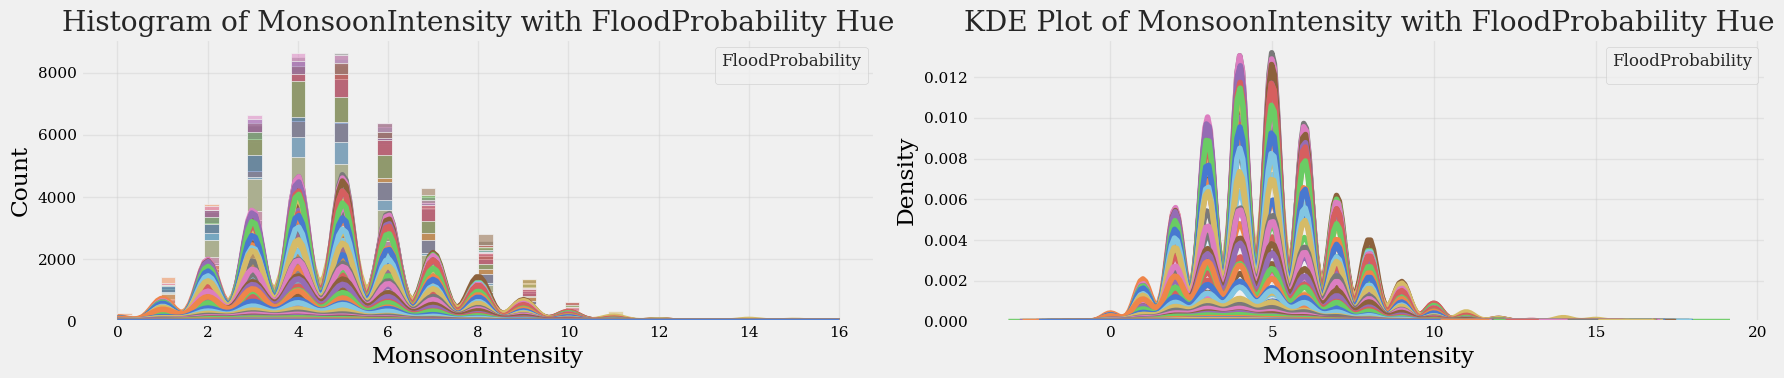

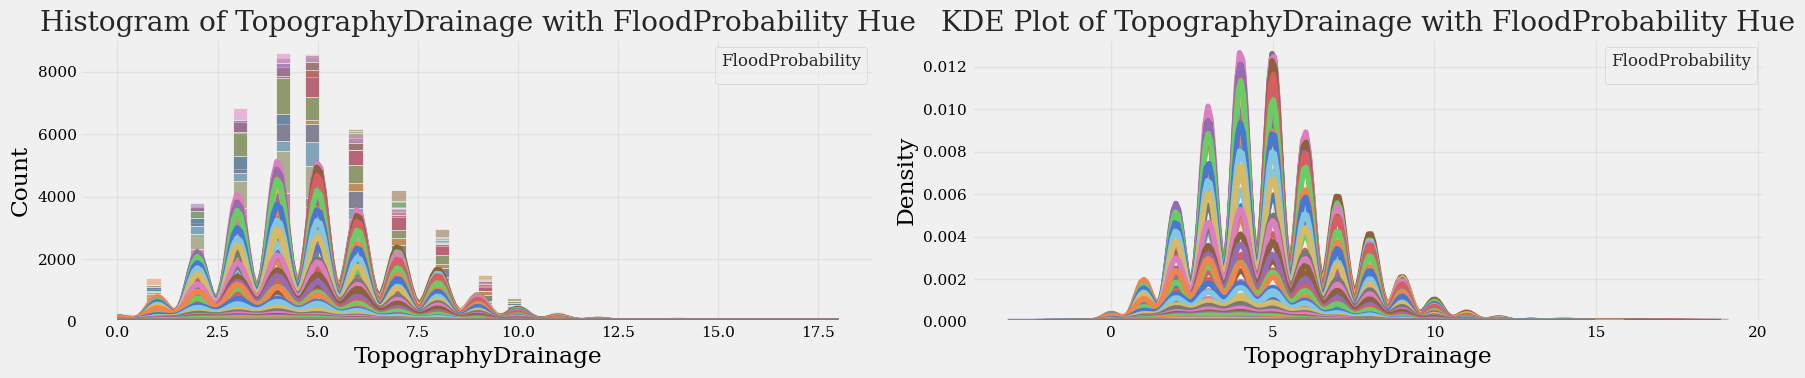

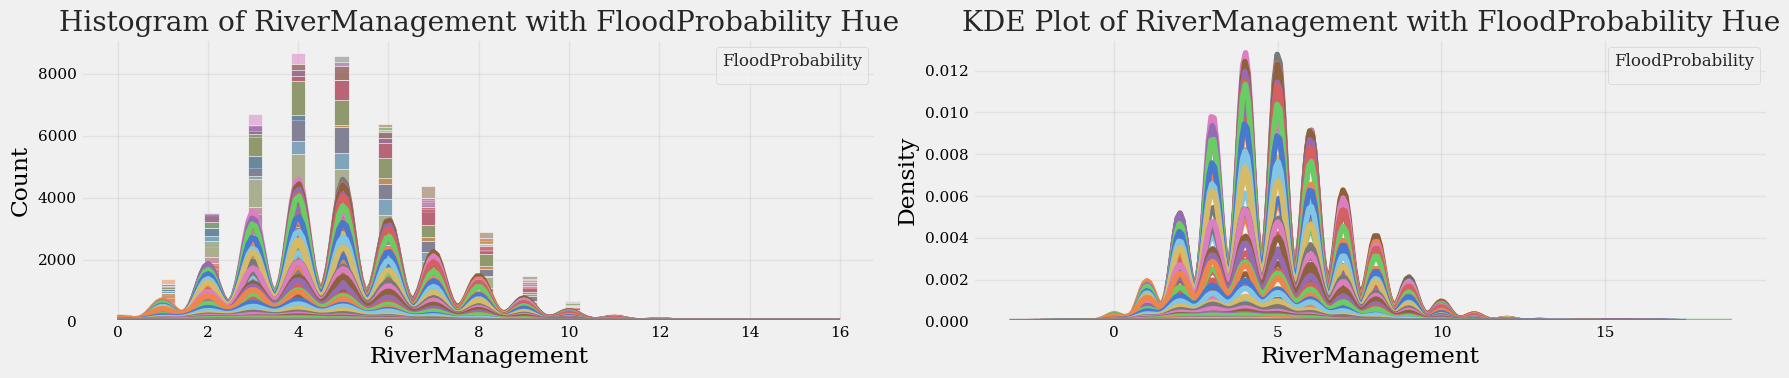

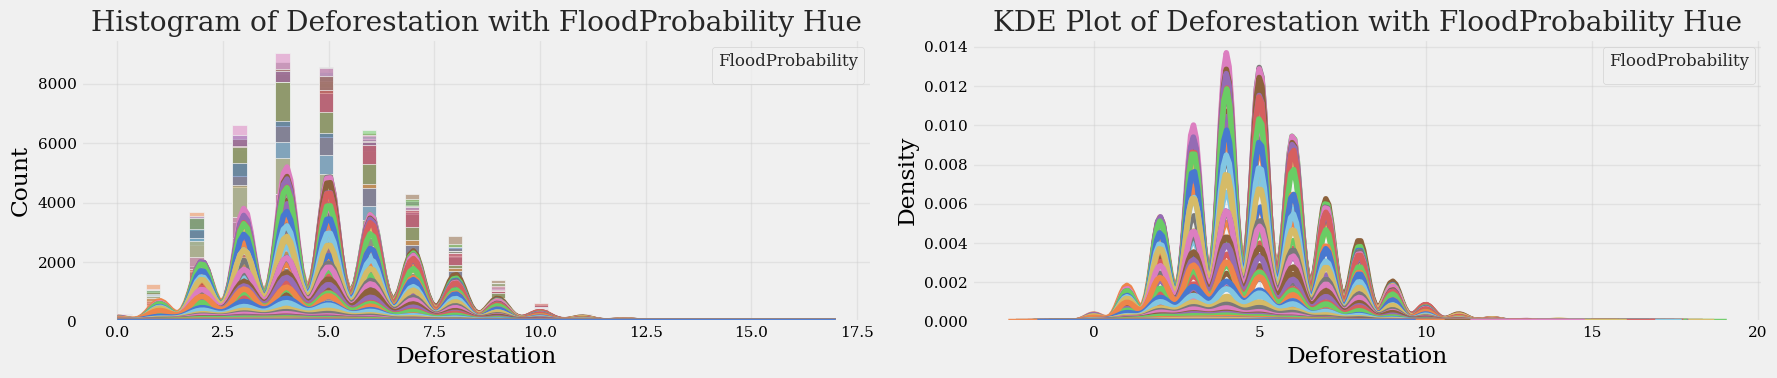

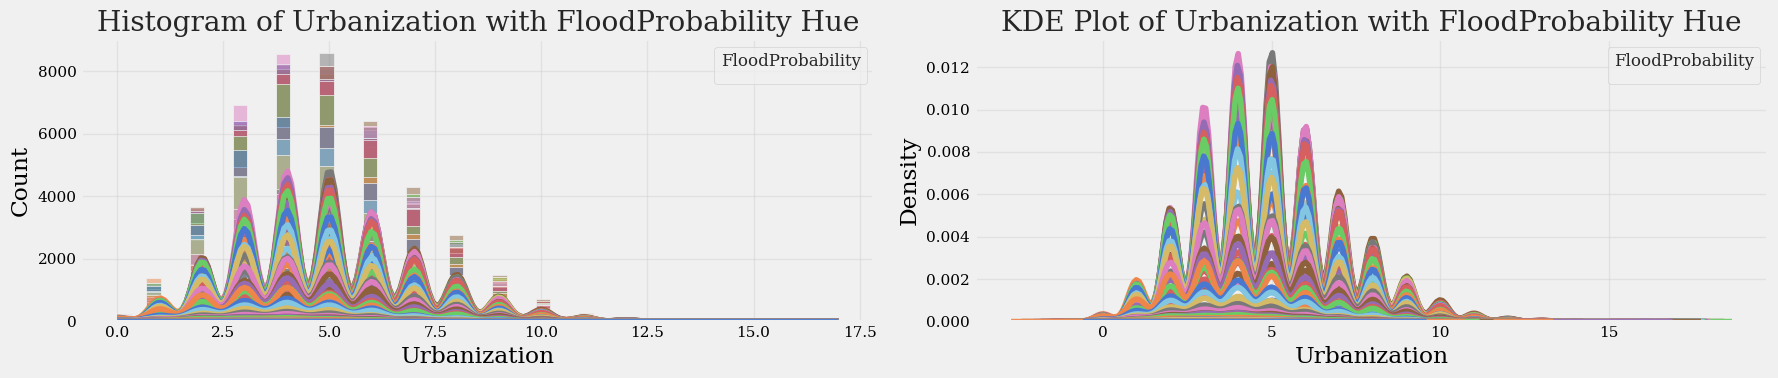

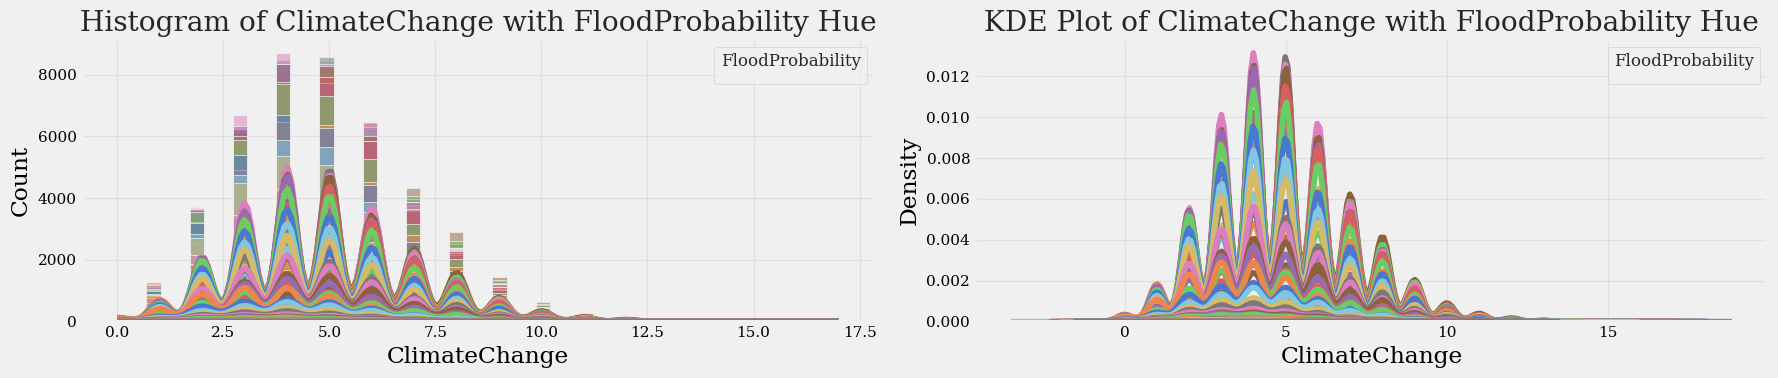

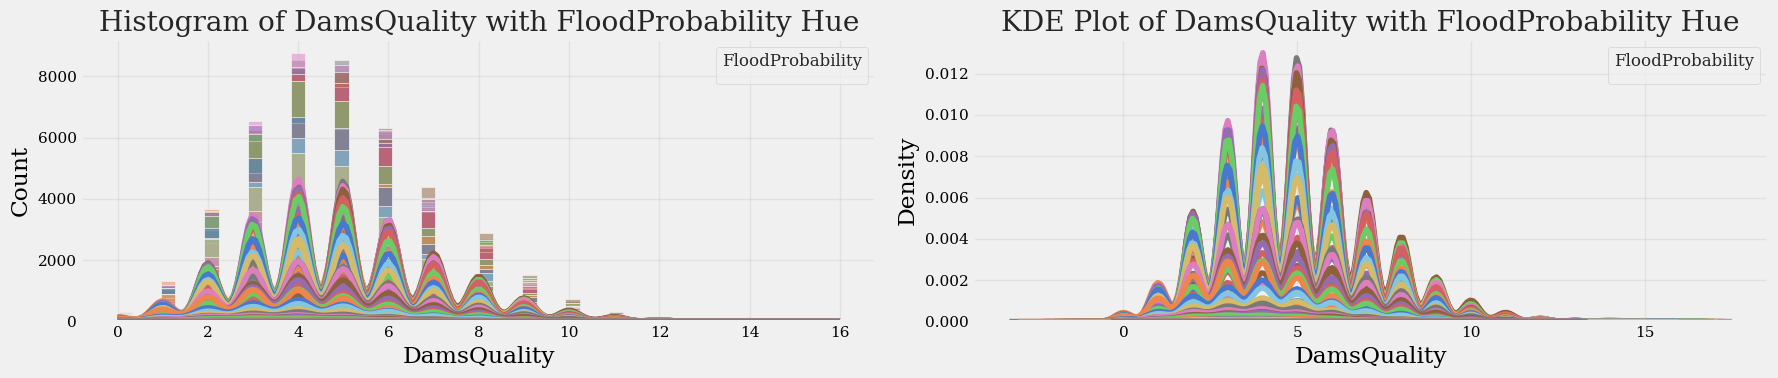

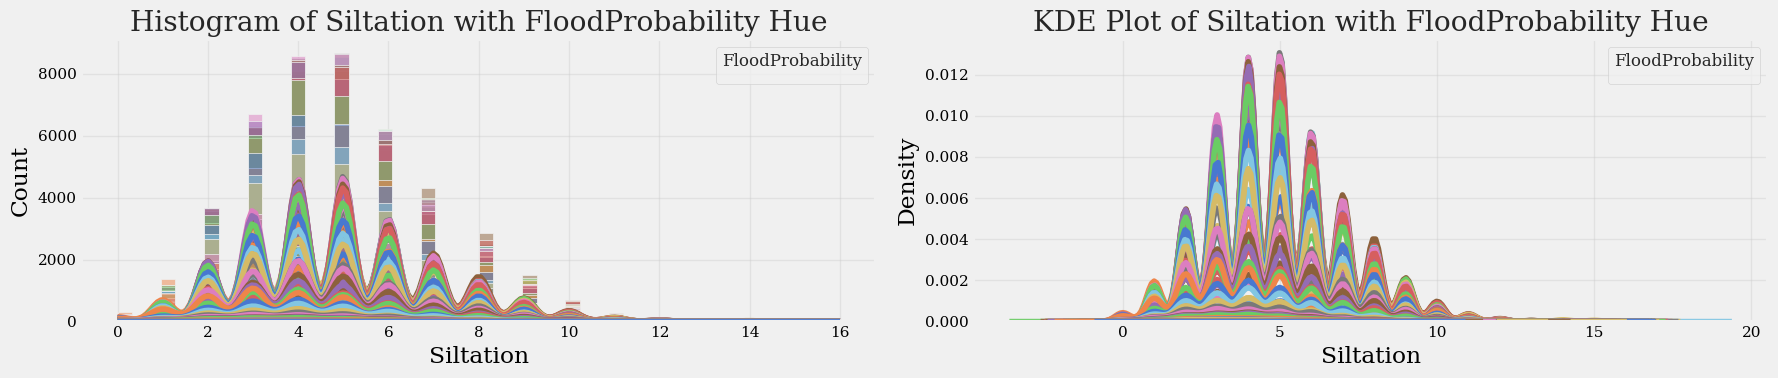

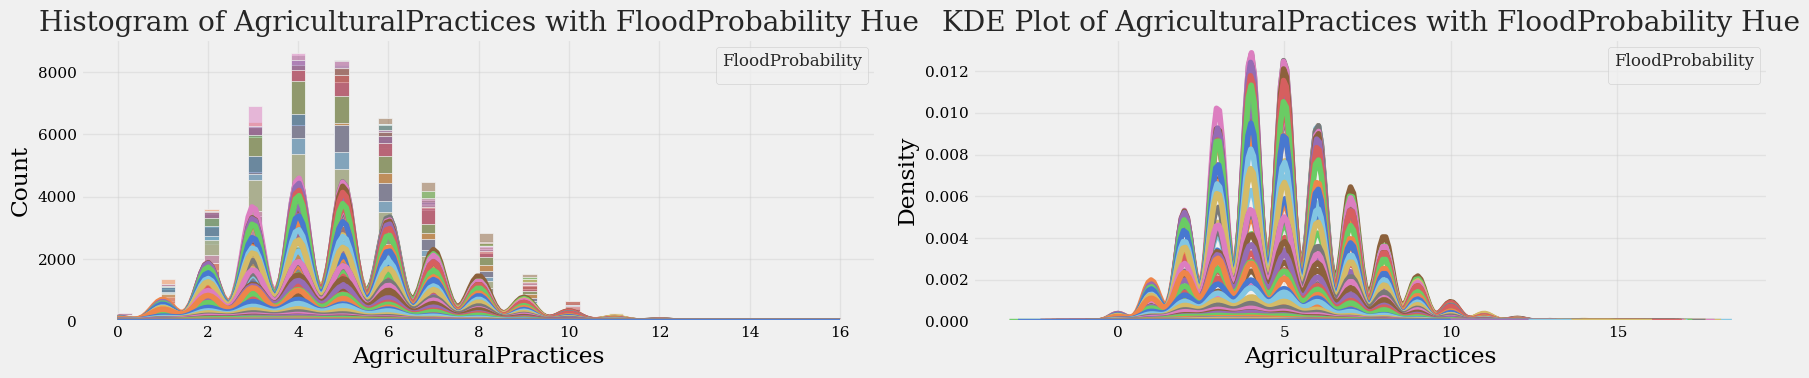

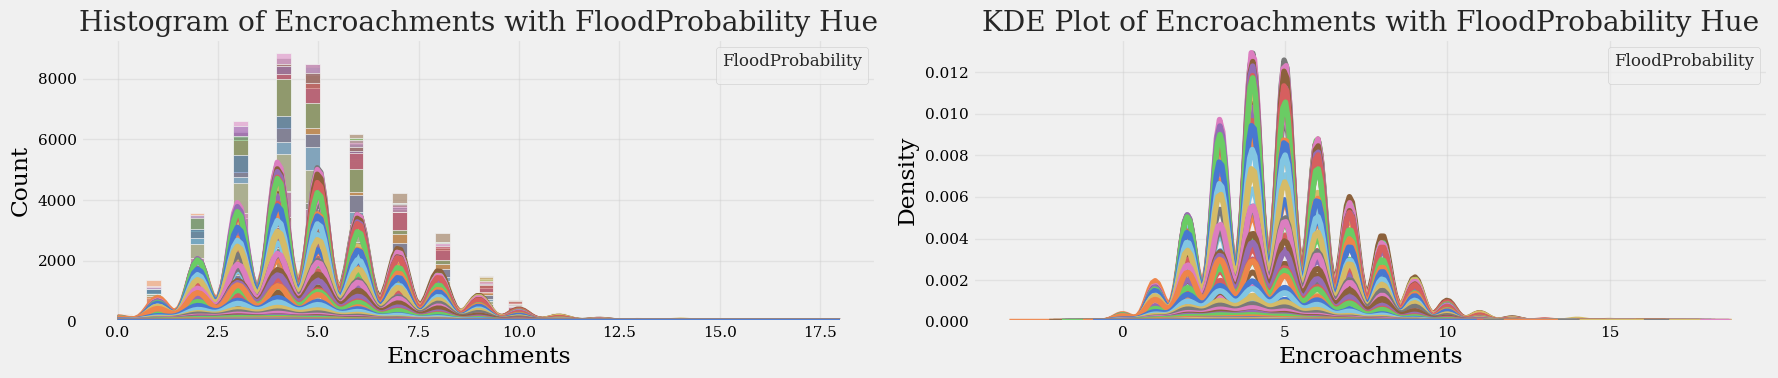

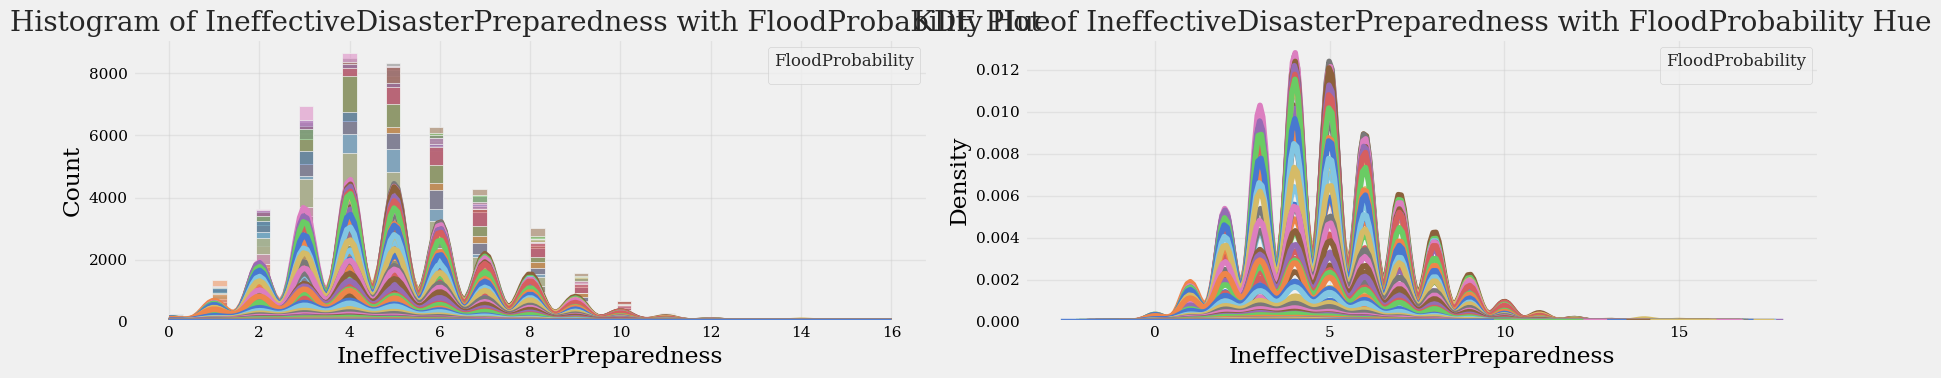

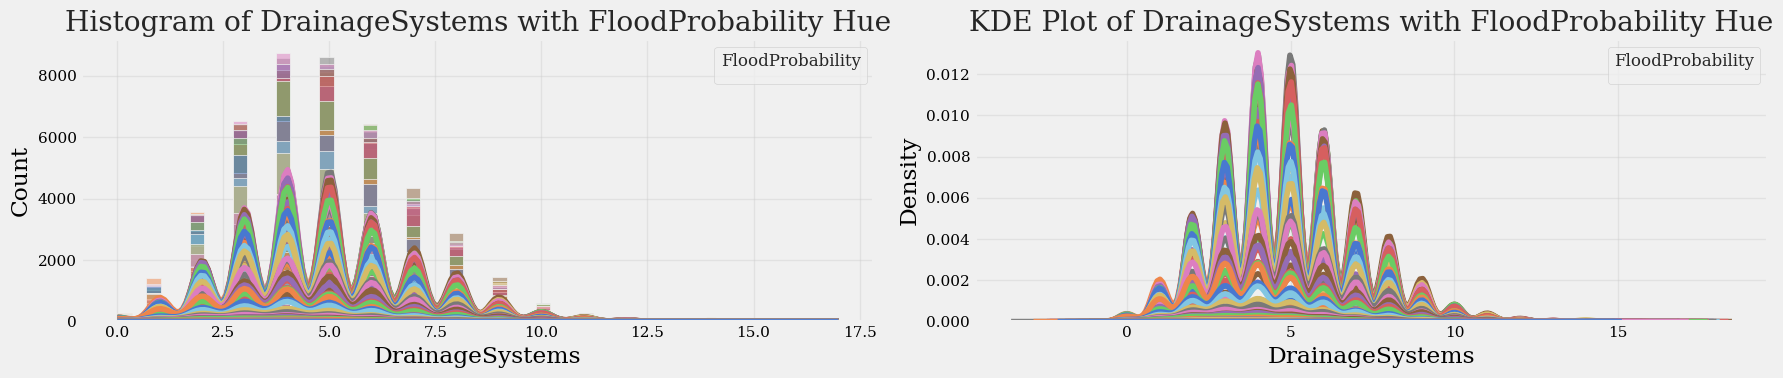

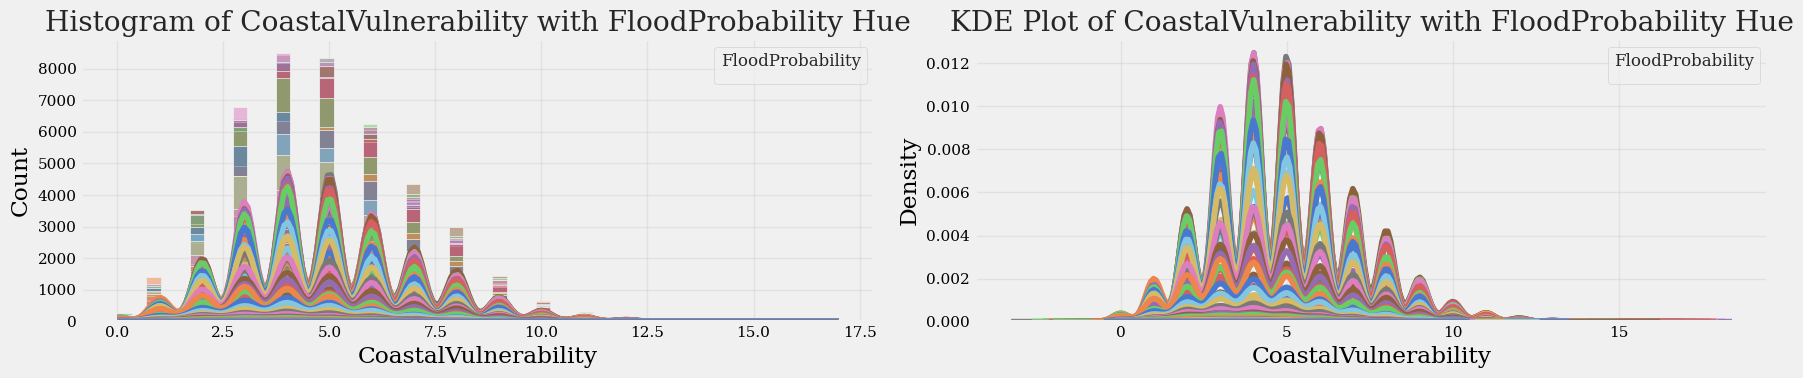

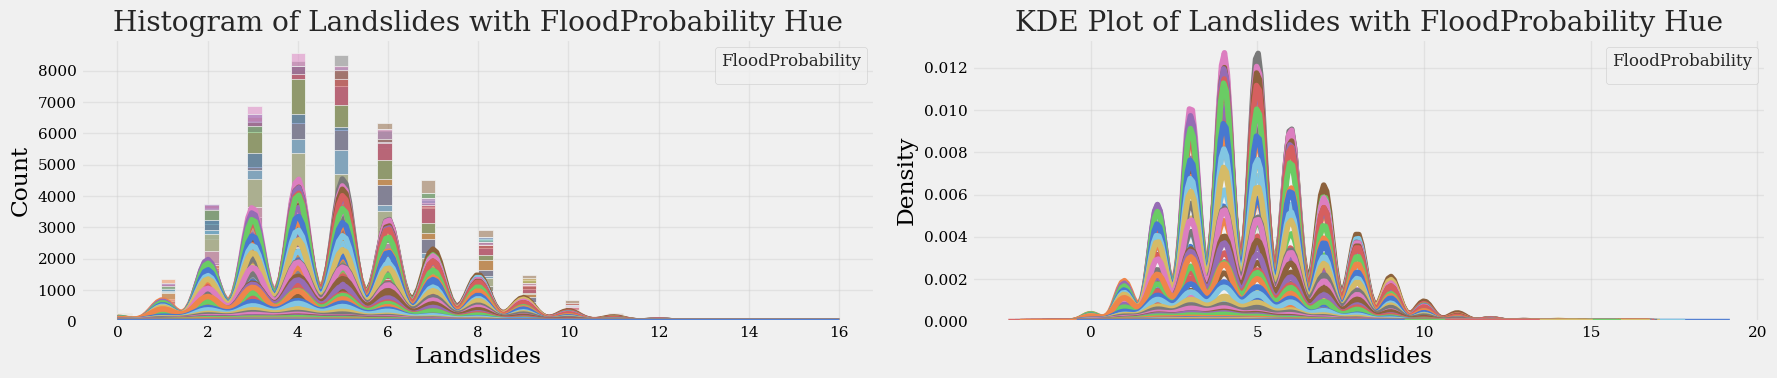

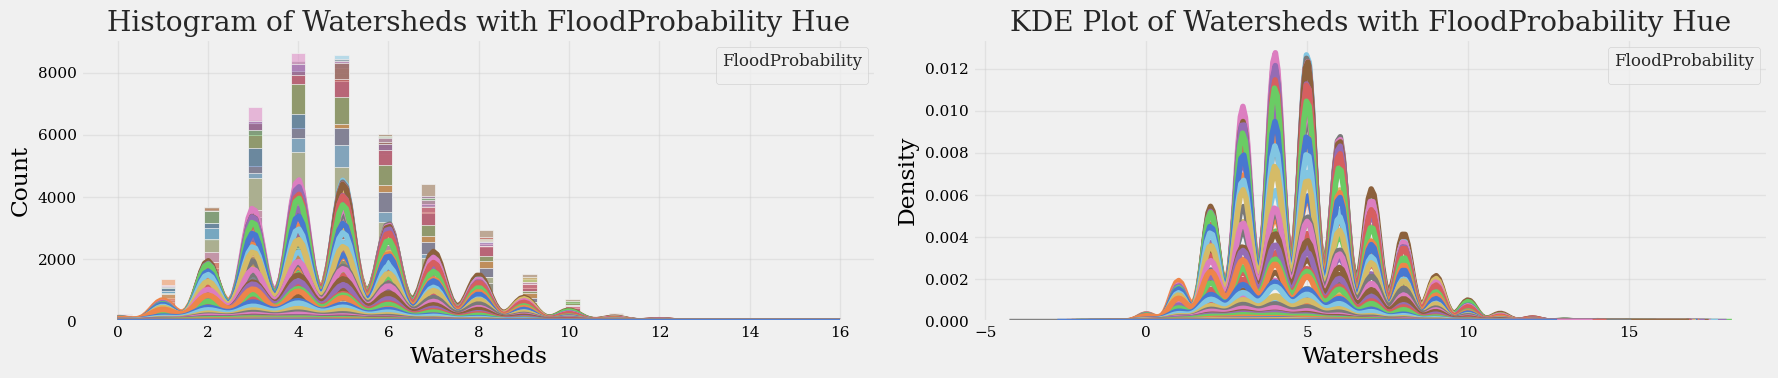

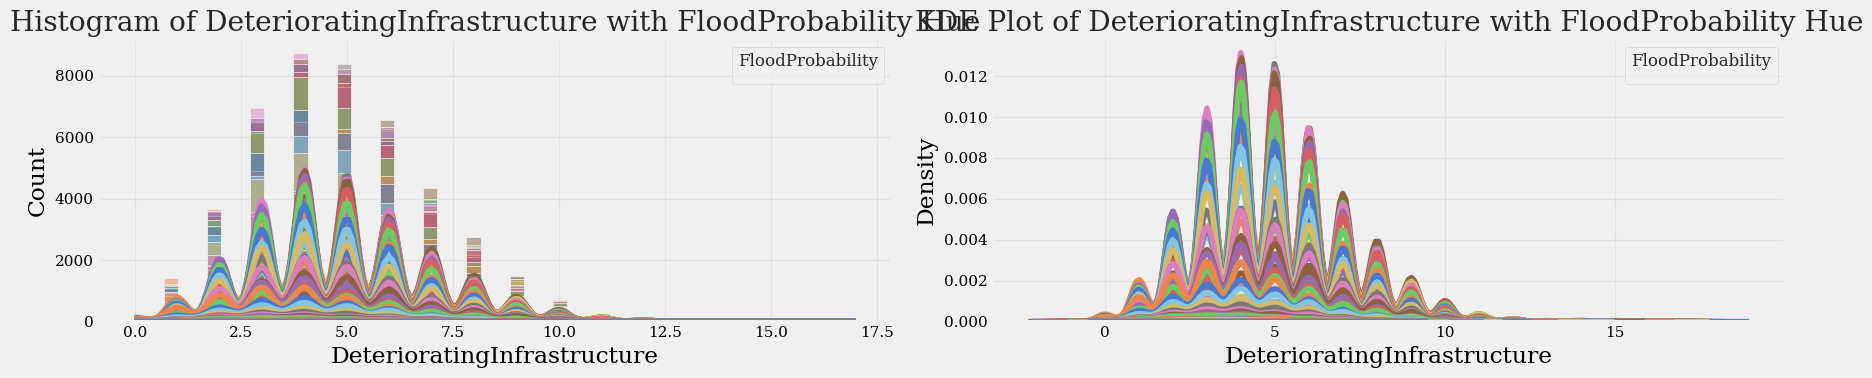

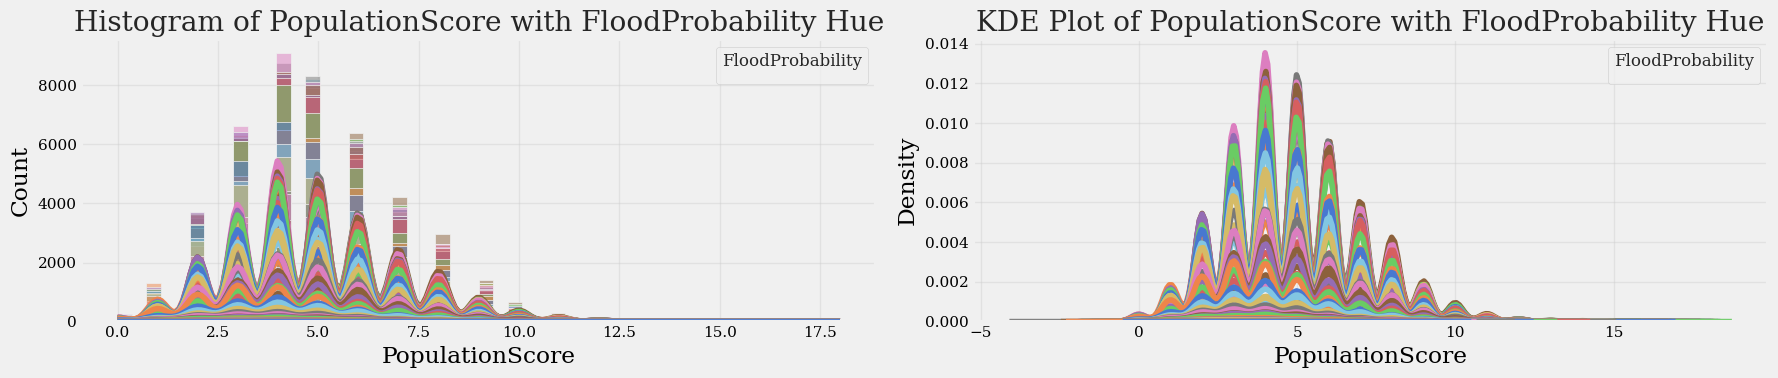

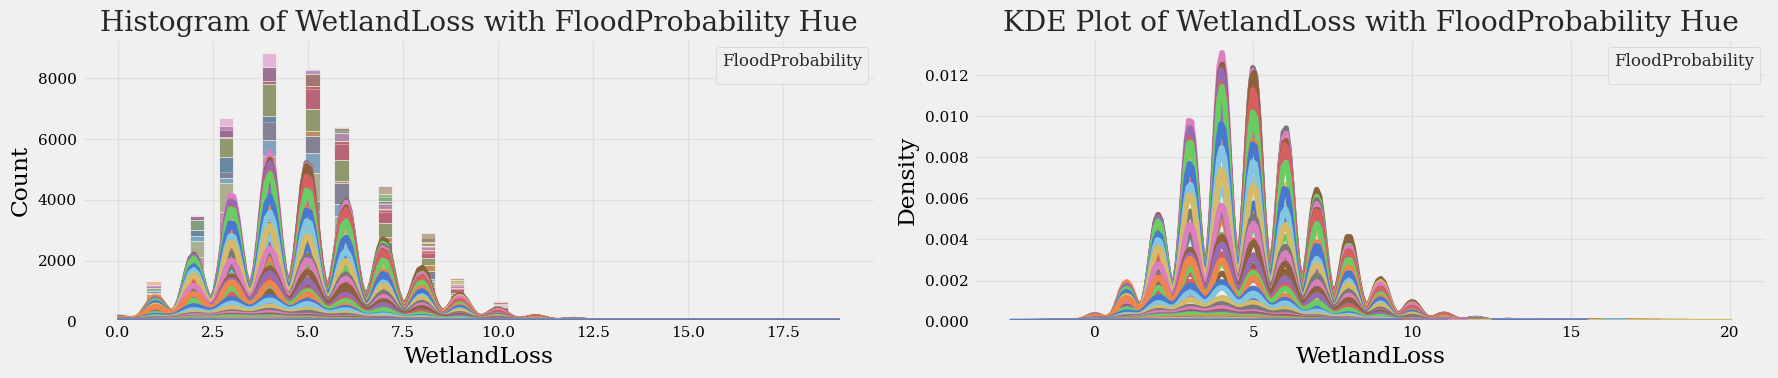

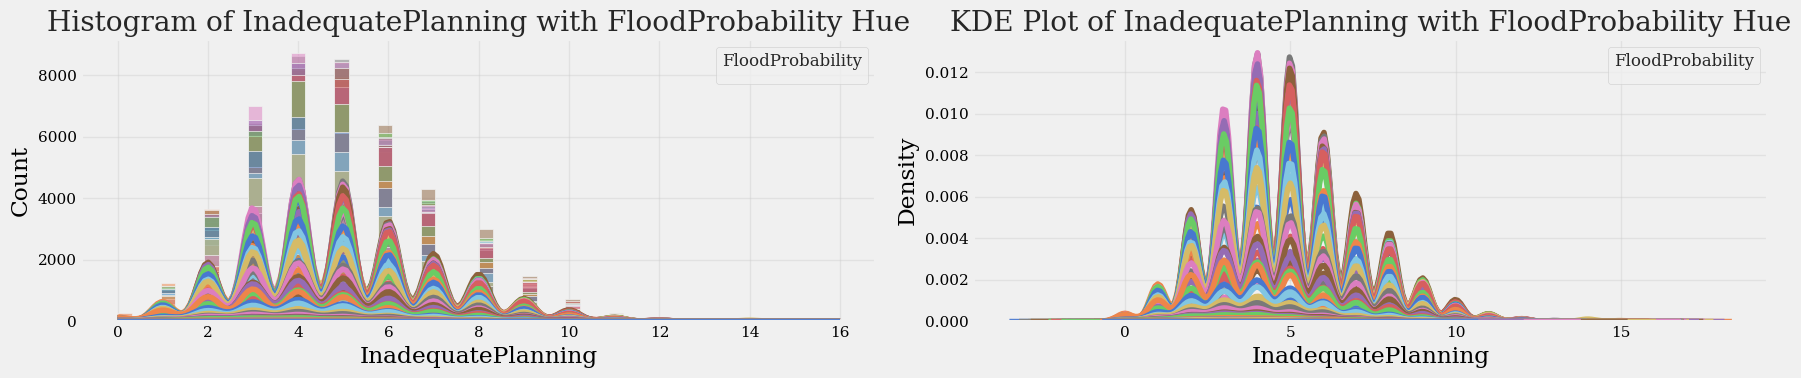

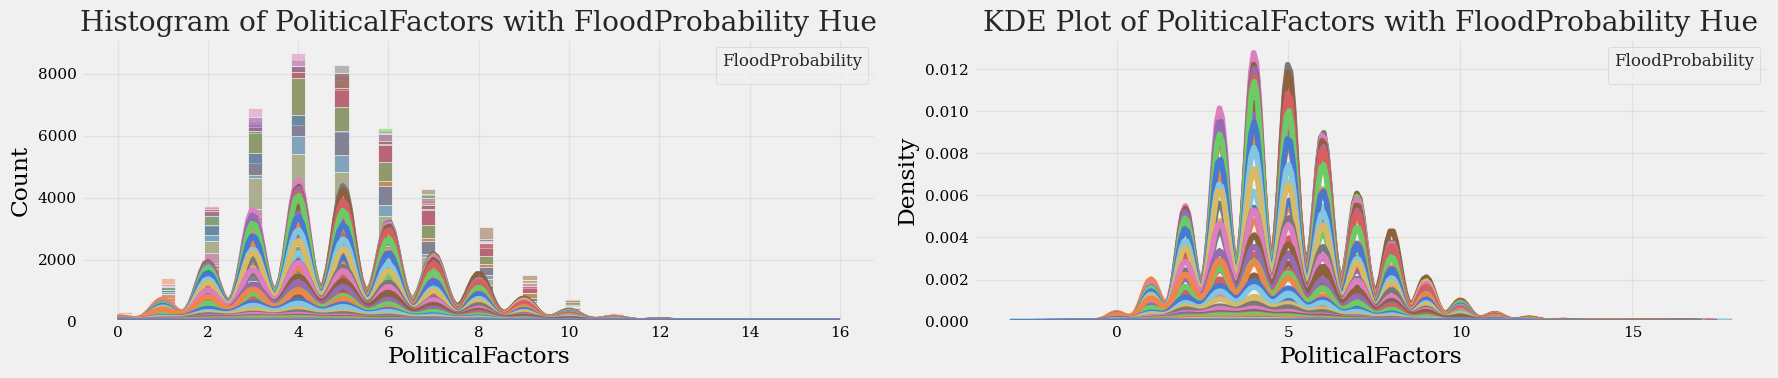

In [19]:
# Set up warnings to be ignored (optional)
warnings.filterwarnings("ignore")
pd.set_option('mode.use_inf_as_na', False)

# List of continuous variables in your dataset
continuous_vars = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', \
                'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness',\
                'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore',\
                   'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']

# Set hue to your target column
target_column = 'FloodProbability'

for column in continuous_vars:
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))  # Create subplots with 1 row and 2 columns
    
    # Plot histogram with hue
    sns.histplot(data=train, x=column, hue=target_column, bins=50, kde=True, ax=axes[0], palette='muted')
    axes[0].set_title(f'Histogram of {column} with {target_column} Hue')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].legend(title=target_column, loc='upper right')
    
    # Plot KDE plot with hue
    sns.kdeplot(data=train, x=column, hue=target_column, ax=axes[1], palette='muted')
    axes[1].set_title(f'KDE Plot of {column} with {target_column} Hue')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Density')
    axes[1].legend(title=target_column, loc='upper right')
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

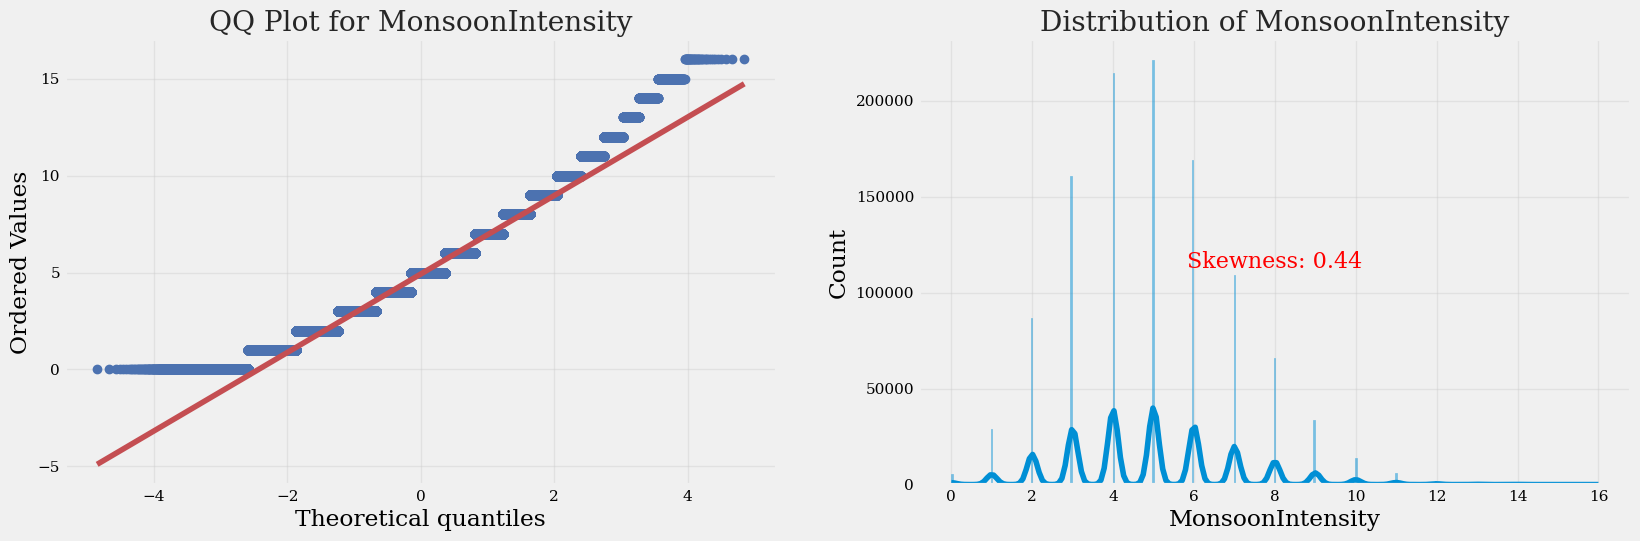

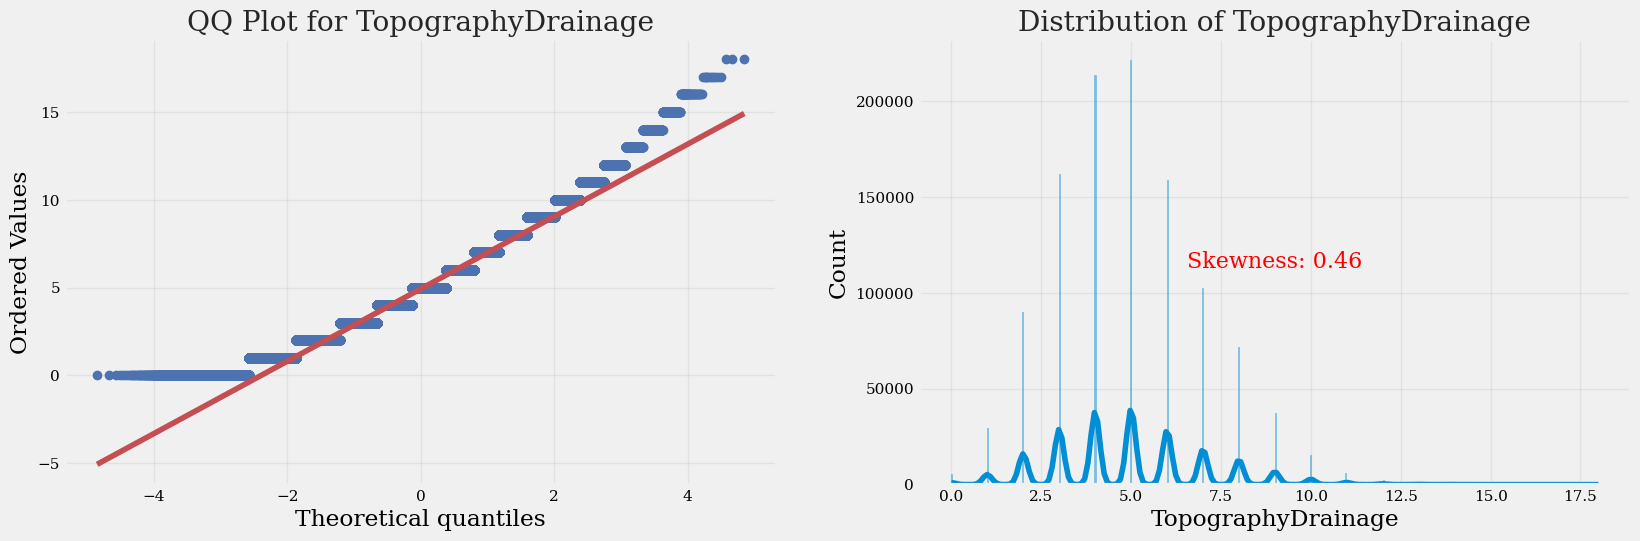

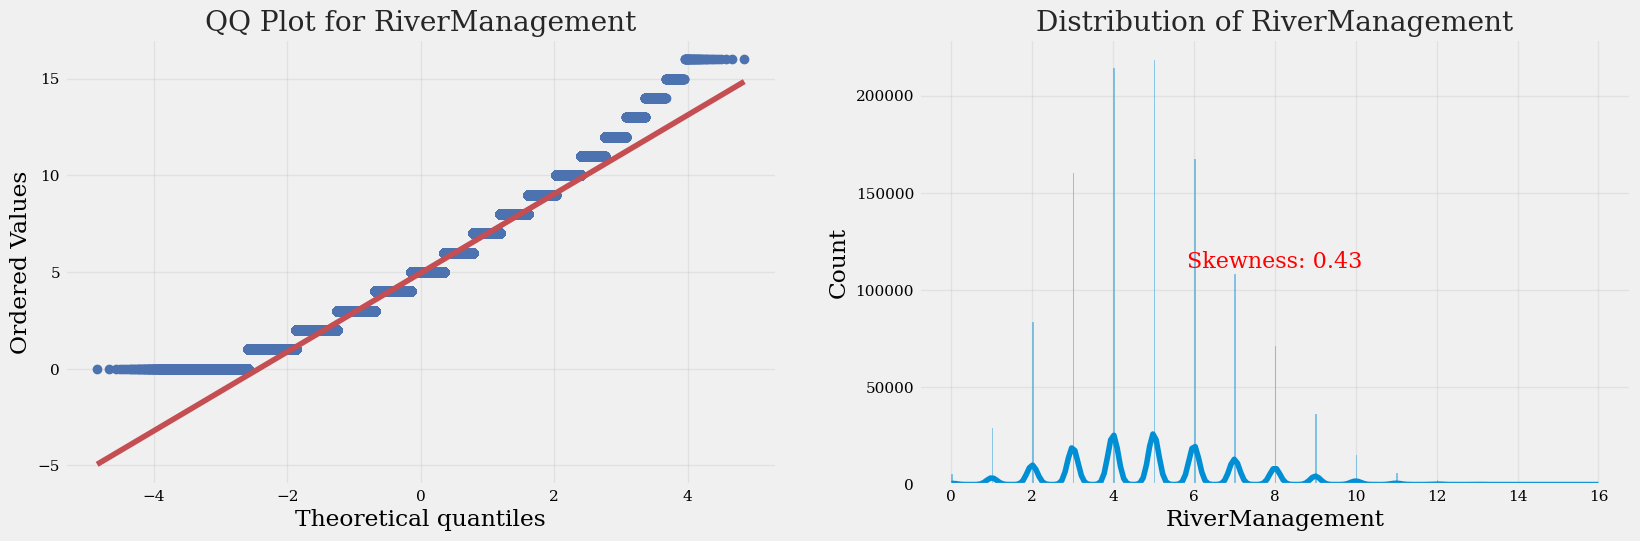

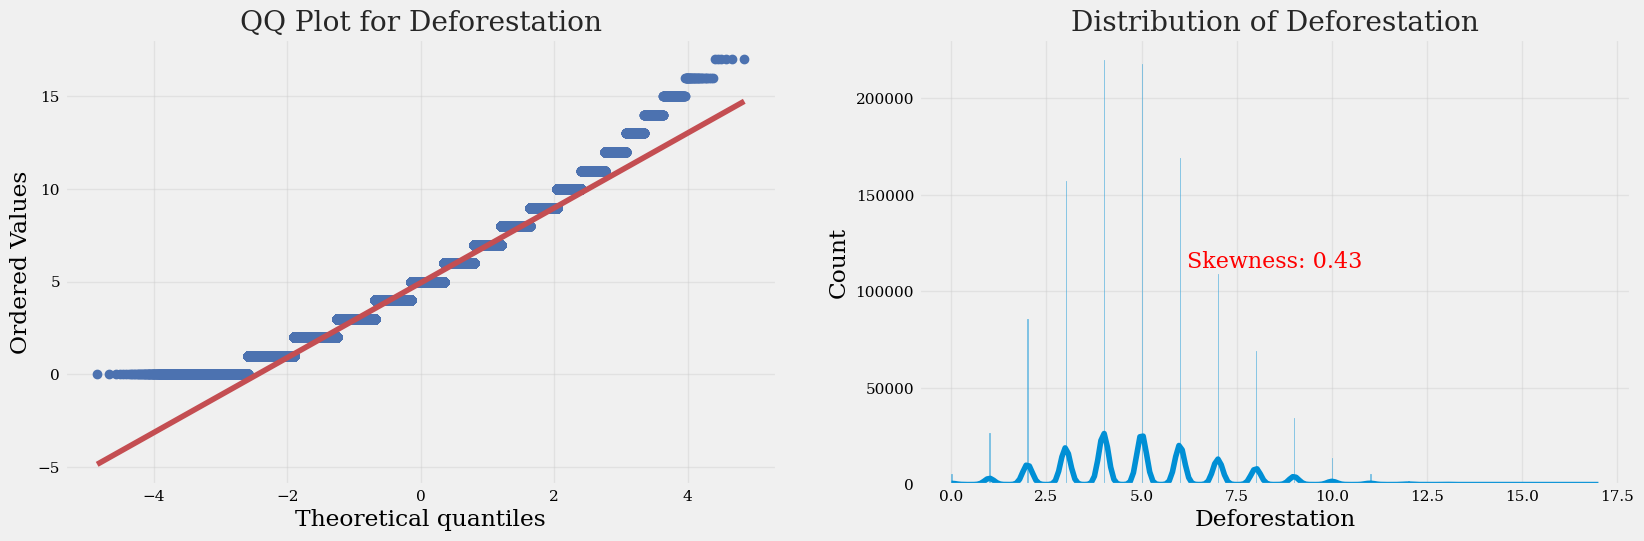

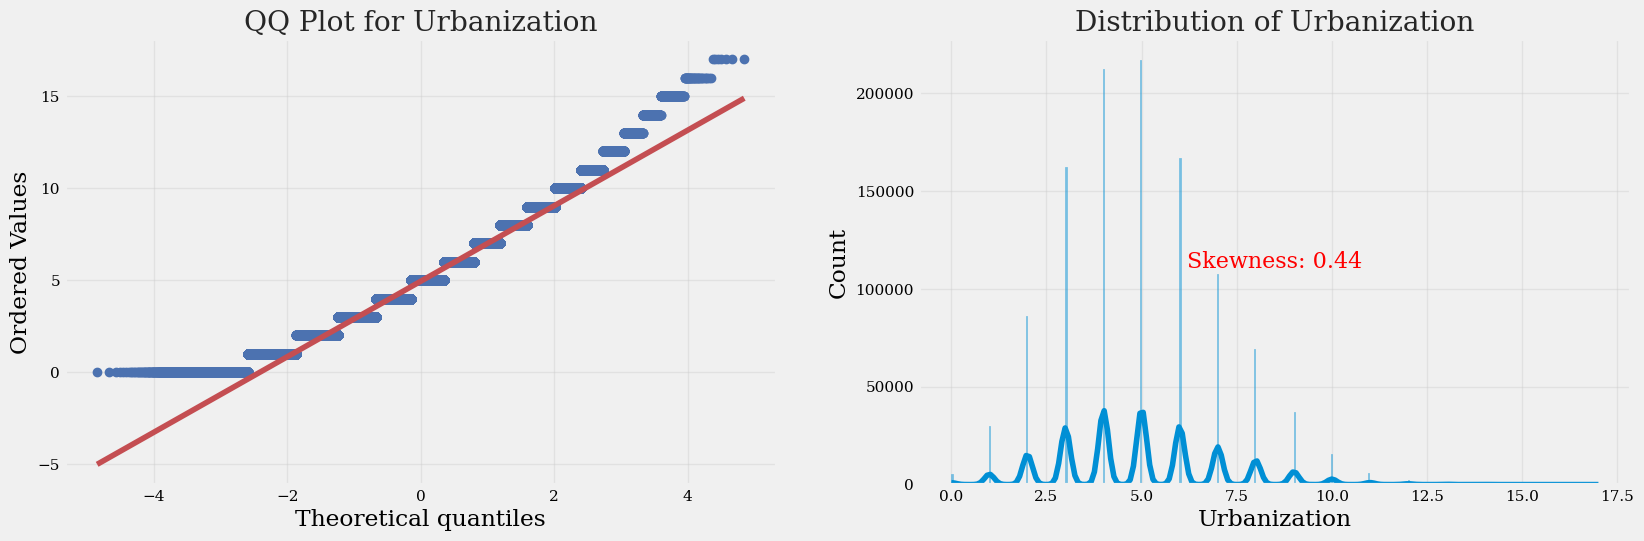

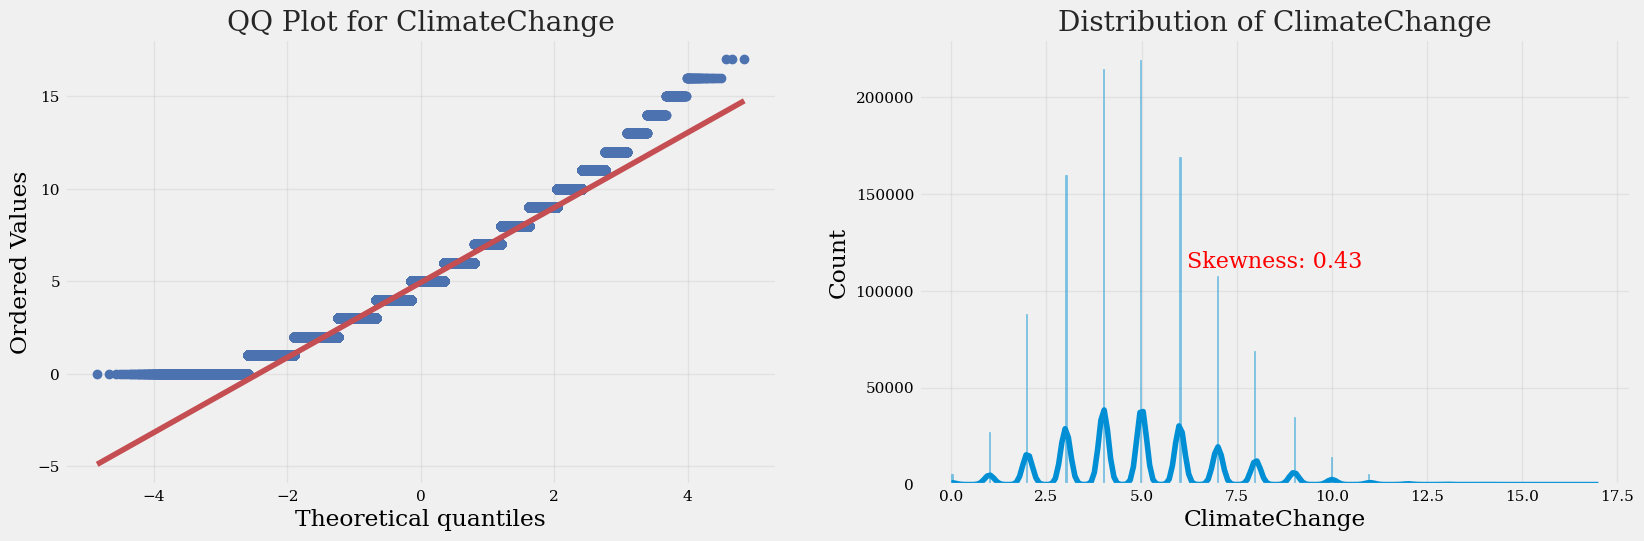

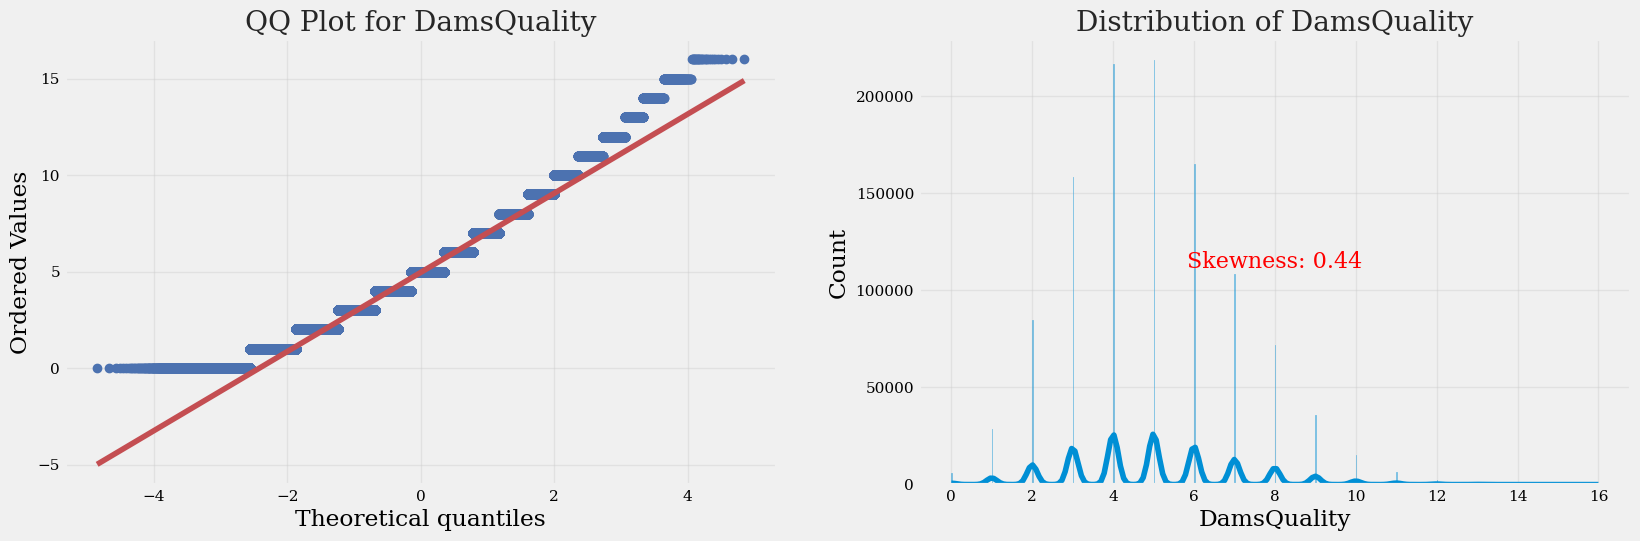

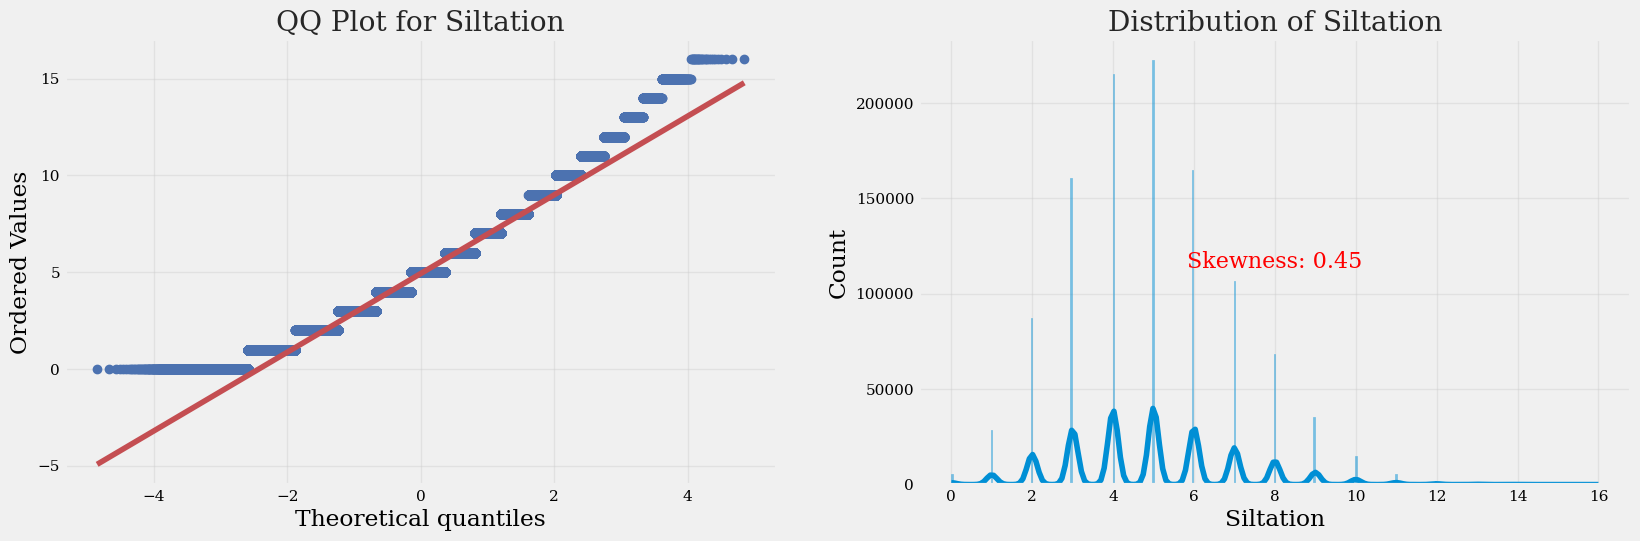

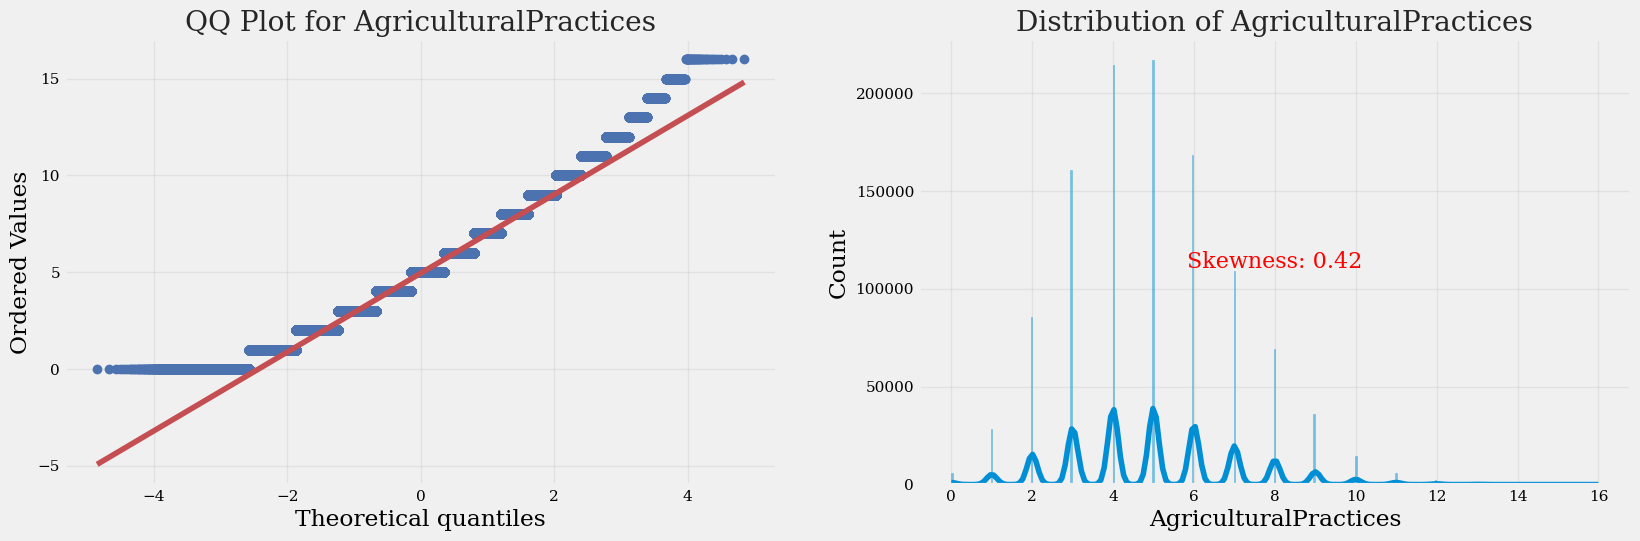

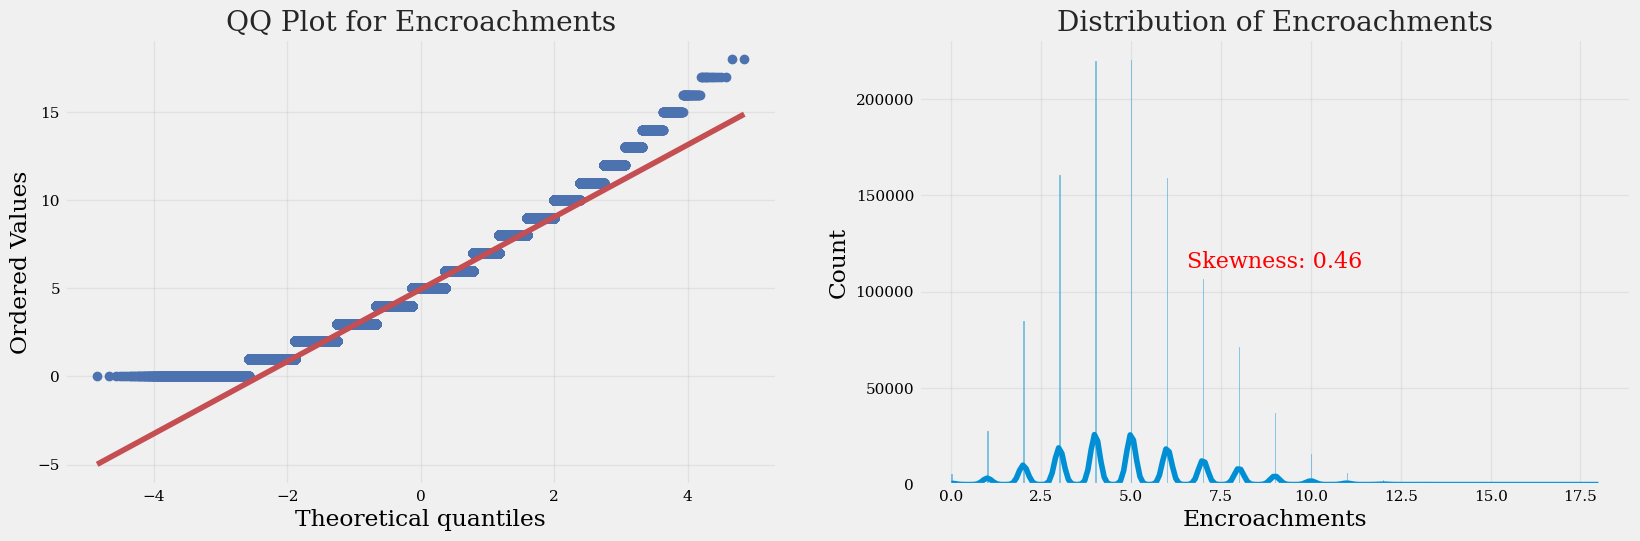

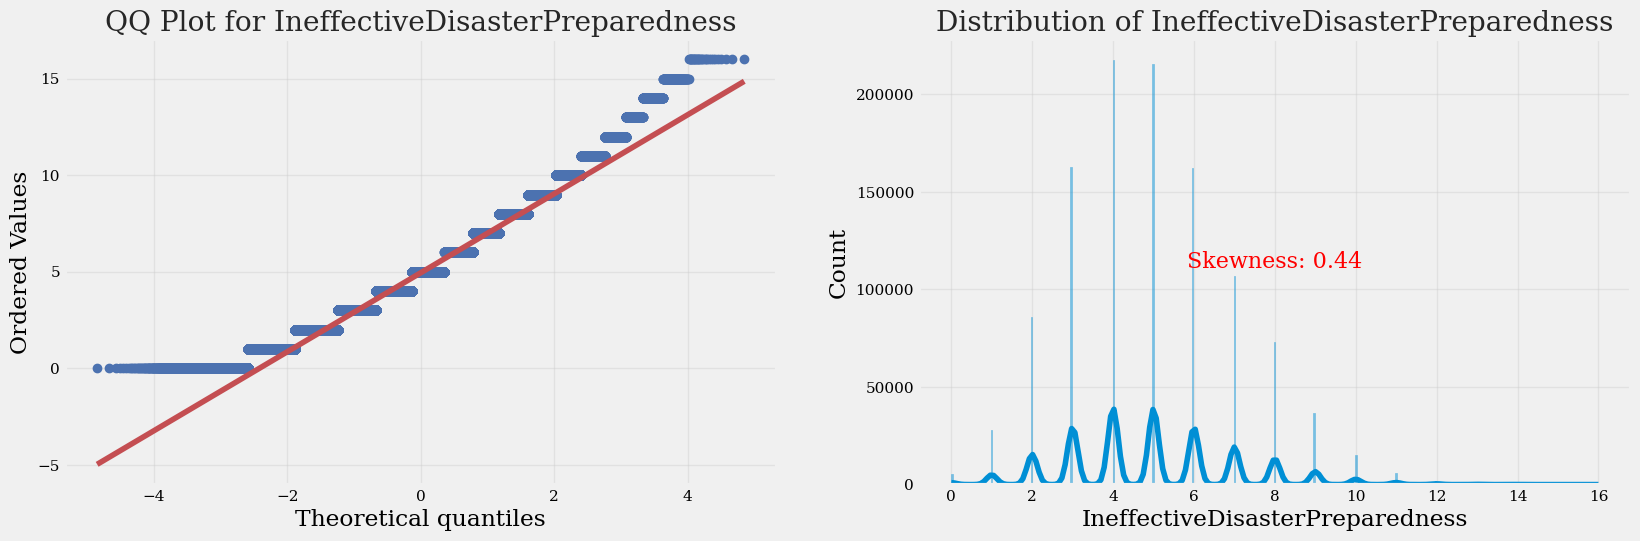

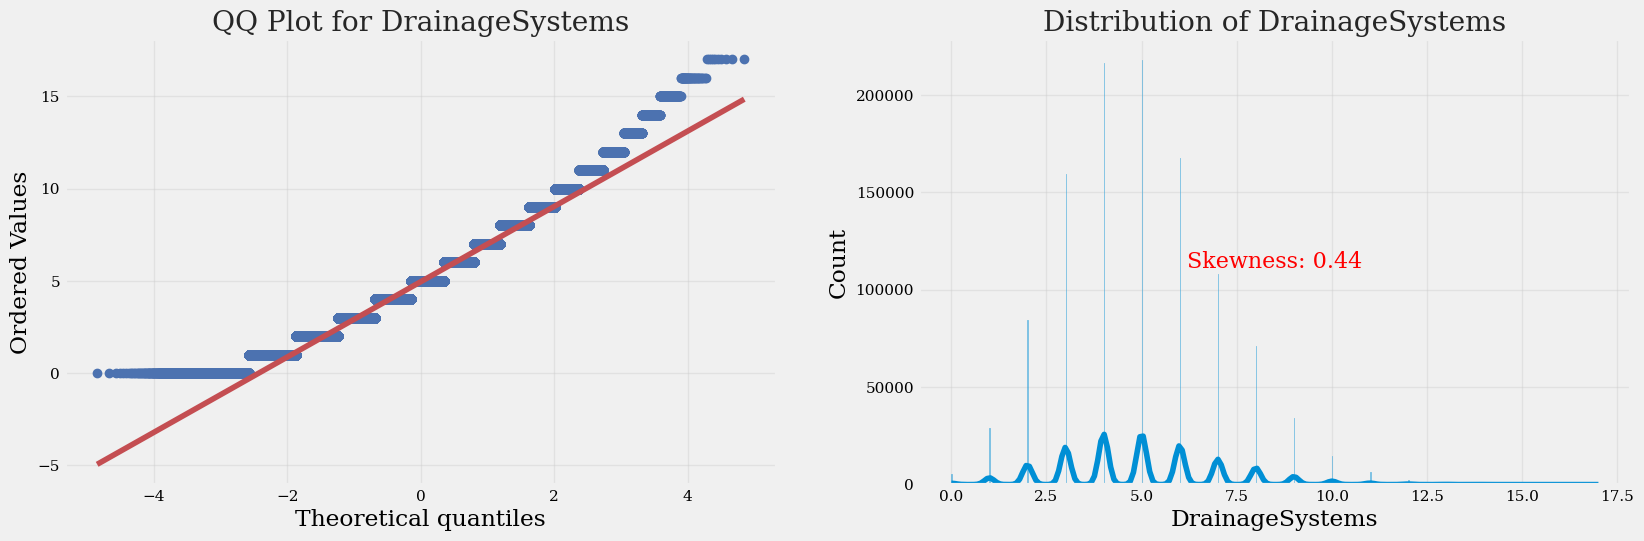

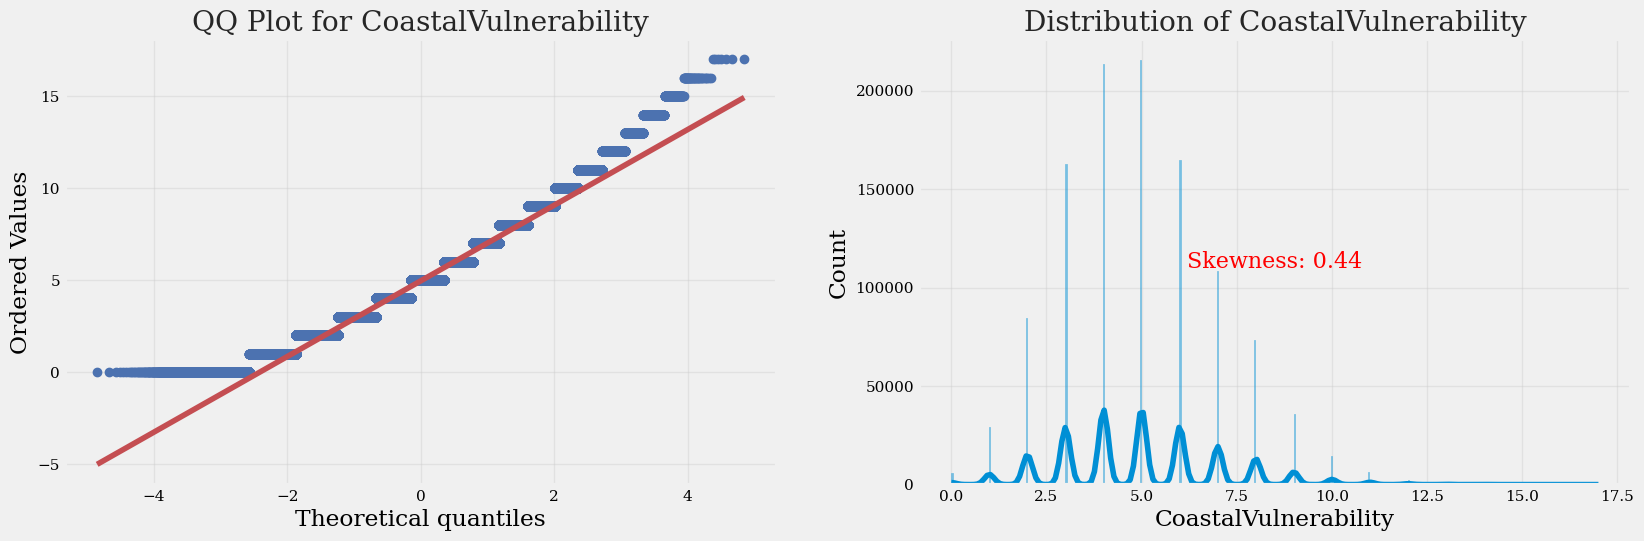

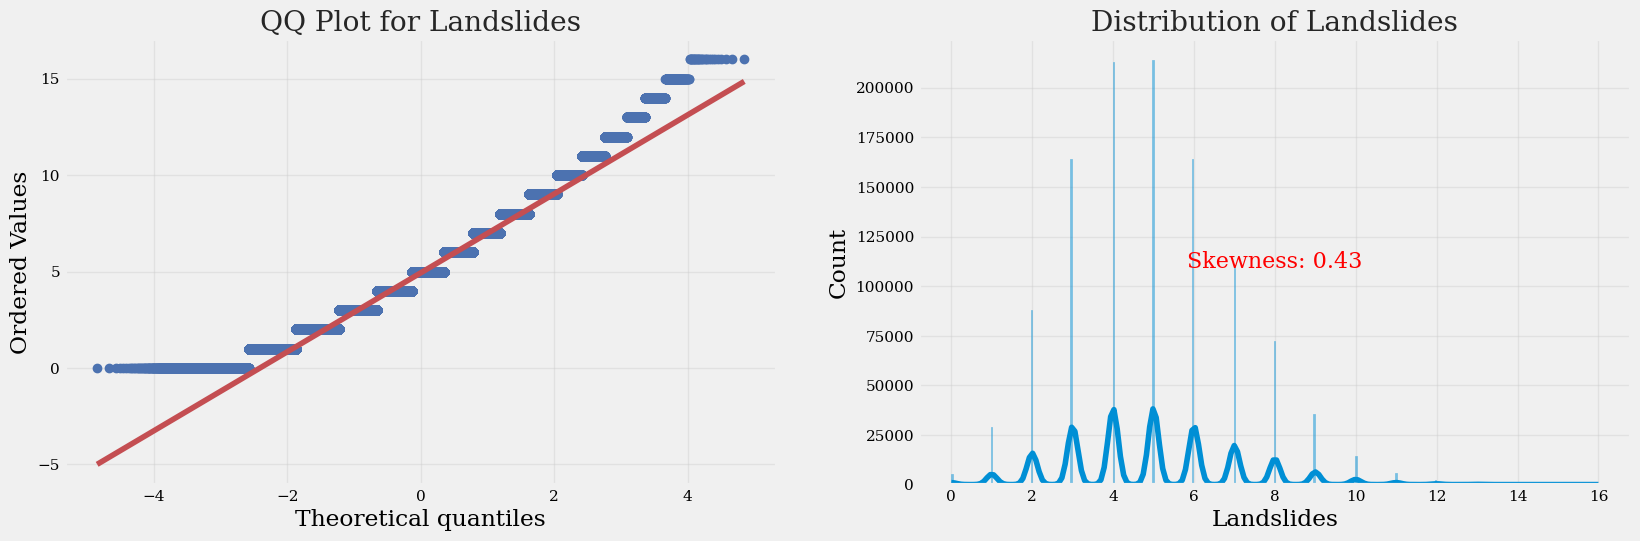

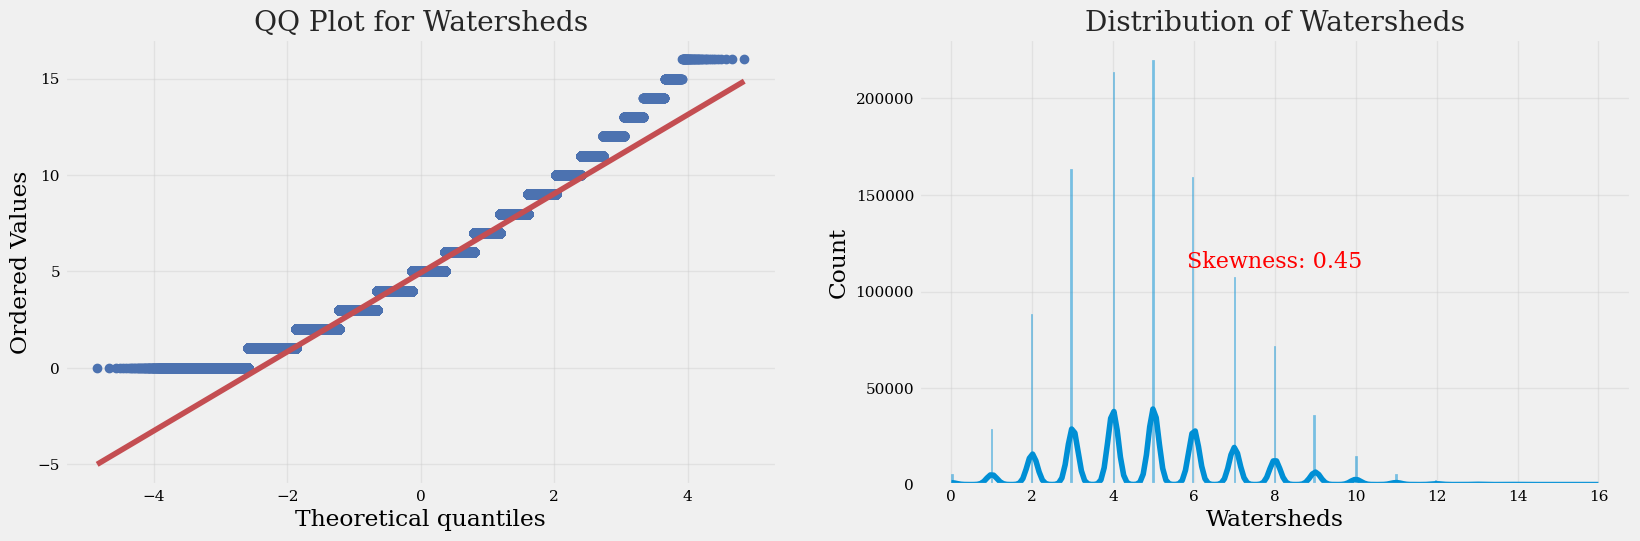

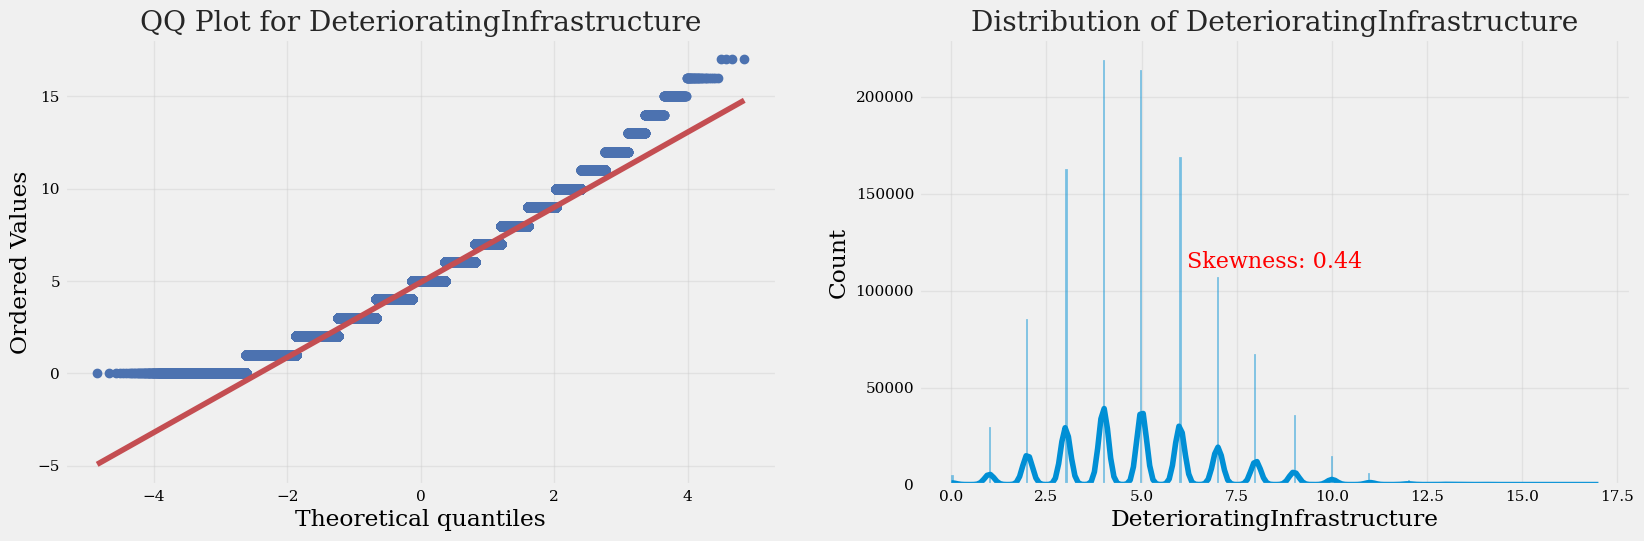

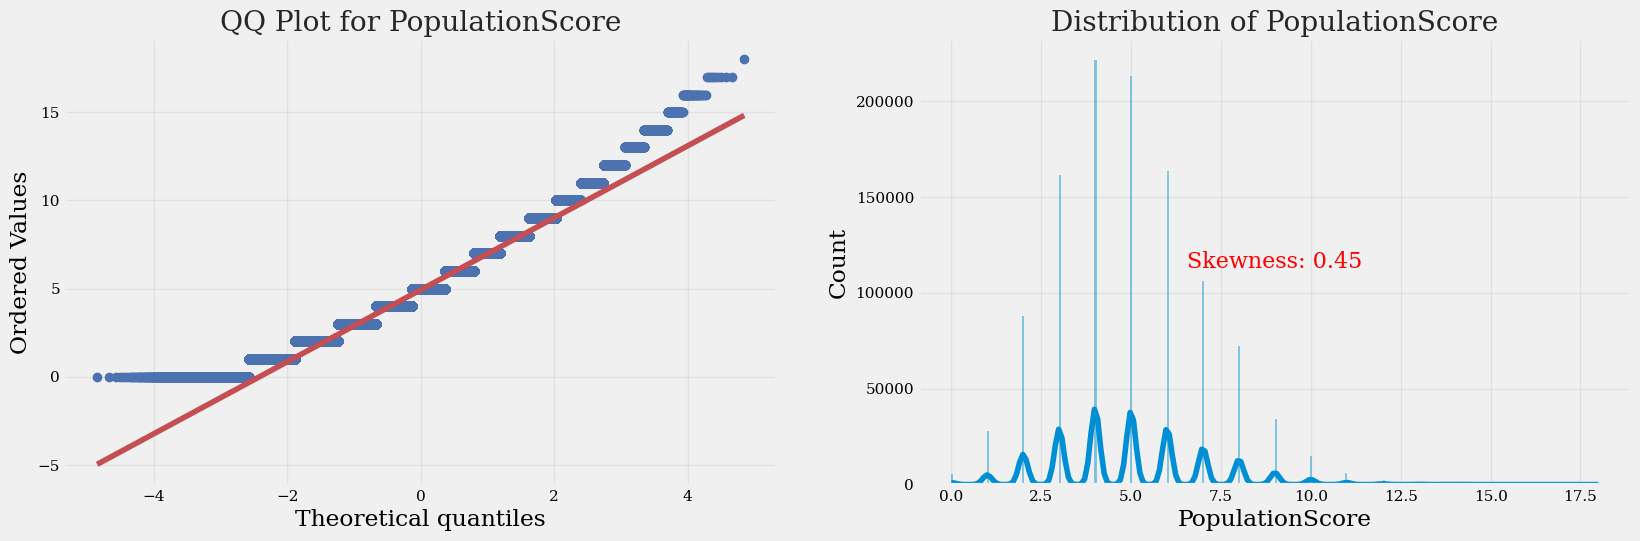

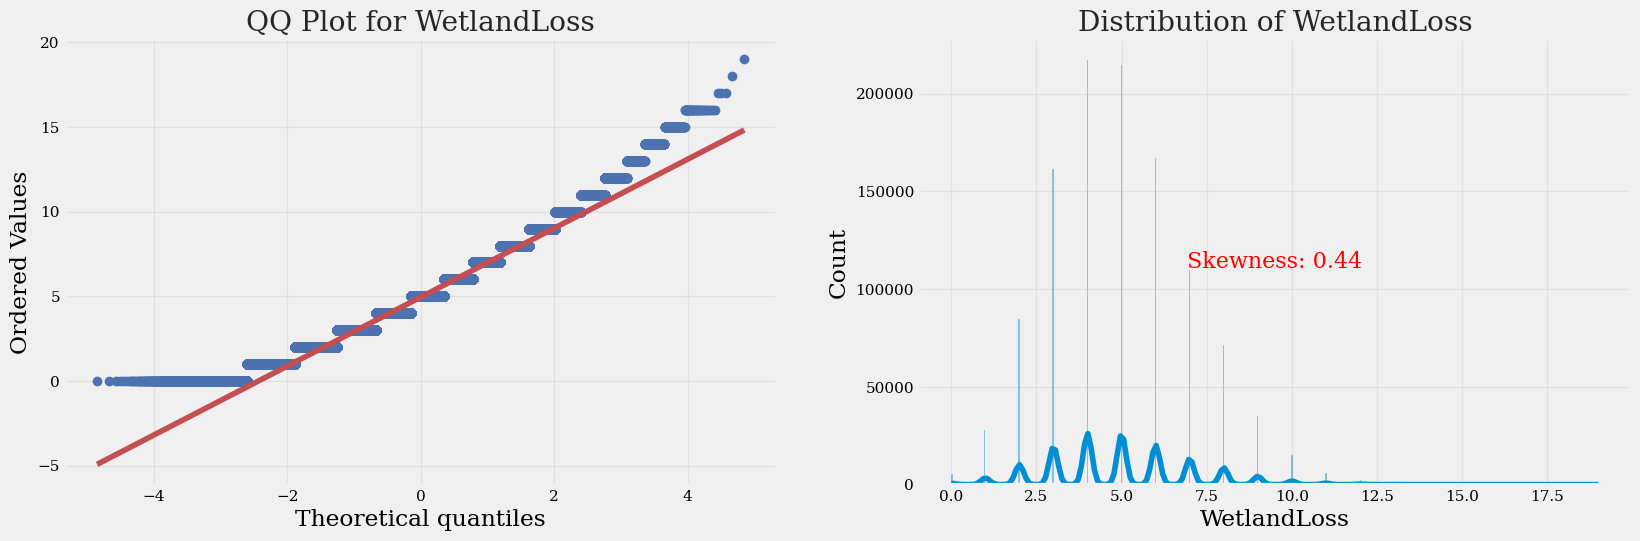

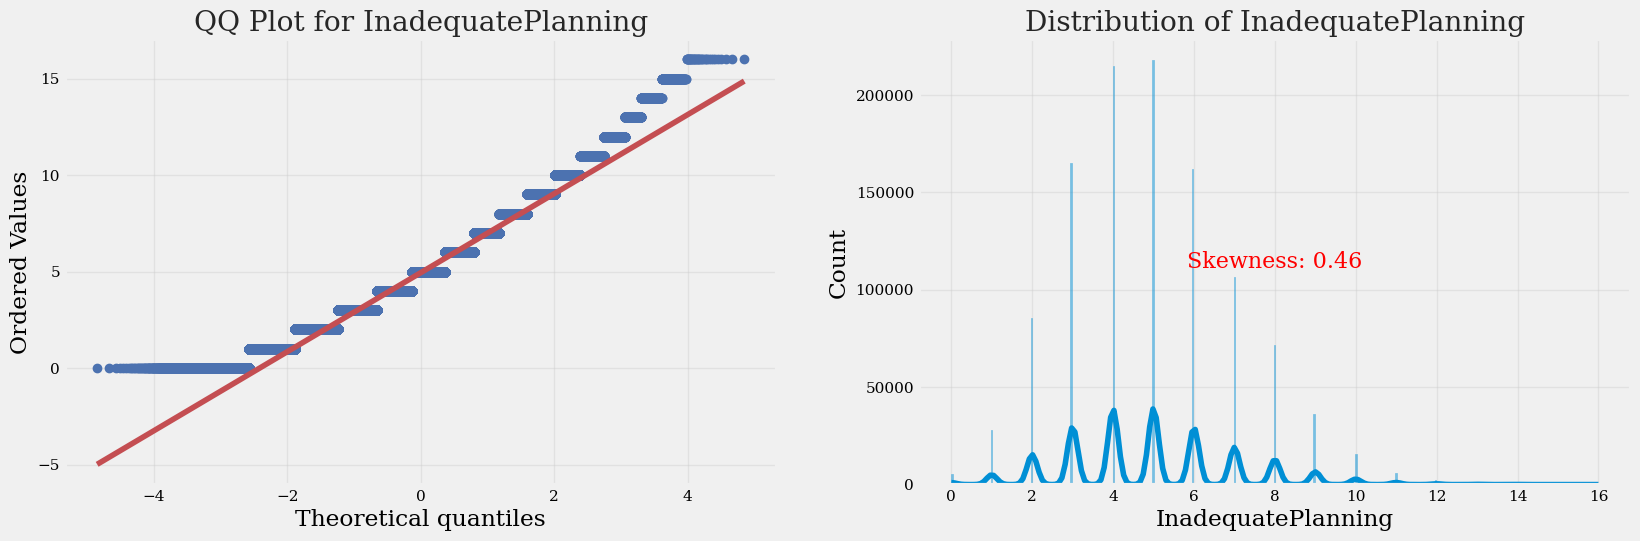

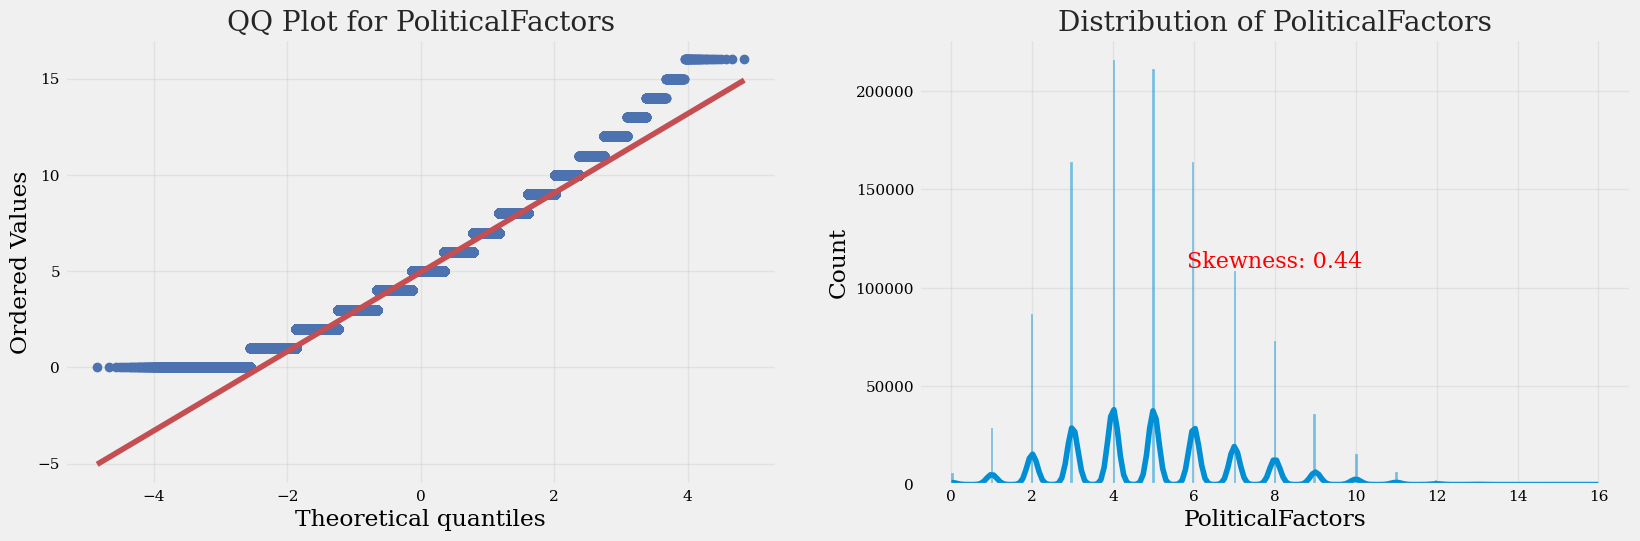

In [20]:
import scipy.stats as stats
def qq_plot_with_skewness(data, quantitative_var):
    if quantitative_var not in data.columns:
        print(f"Error: '{quantitative_var}' not found in the DataFrame.")
        return
    
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
    if data[quantitative_var].isnull().any():
        print(f"Warning: '{quantitative_var}' contains missing values. Results may be affected.")
    
    # QQ plot
    stats.probplot(data[quantitative_var], plot=ax[0], fit=True)
    ax[0].set_title(f'QQ Plot for {quantitative_var}')

    # Skewness plot
    sns.histplot(data[quantitative_var], kde=True, ax=ax[1])
    ax[1].set_title(f'Distribution of {quantitative_var}')

    # Calculate skewness value
    skewness_value = stats.skew(data[quantitative_var])

    # Display skewness value on the plot
    ax[1].text(0.5, 0.5, f'Skewness: {skewness_value:.2f}', transform=ax[1].transAxes, 
               horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')

    plt.show()
# Example usage for each continuous variable
for var in continuous_vars:
    qq_plot_with_skewness(train, var)



### Outliers Check

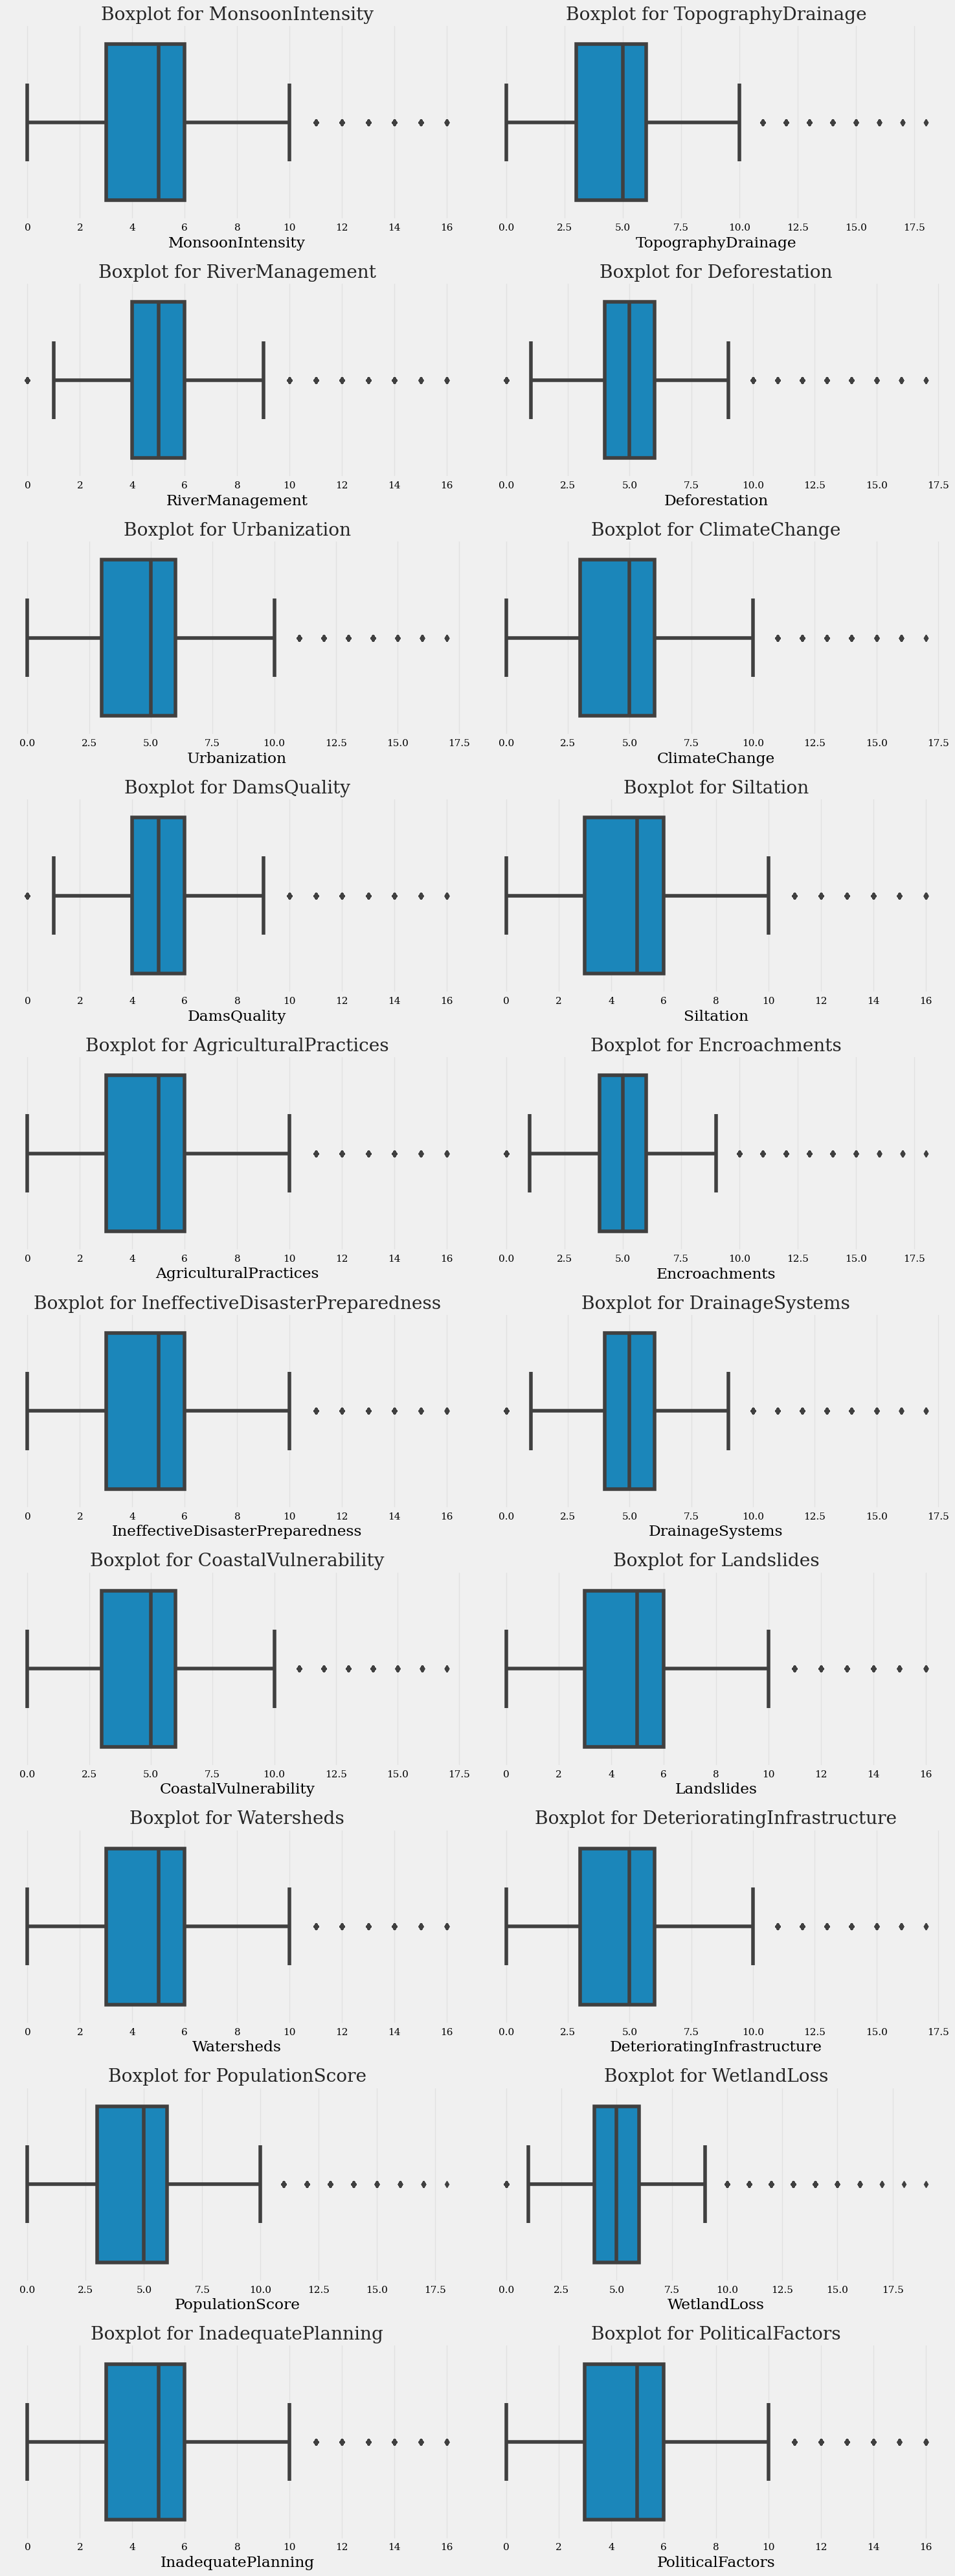

In [21]:
def plot_boxplots(data, columns, ncols=2):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

    for i, column in enumerate(columns):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i % ncols]

        if data[column].dtype == 'O':  # 'O' represents object (categorical) dtype
            sns.countplot(x=column, data=data, ax=ax)
            ax.set_title(f'Countplot for {column}')
        else:
            sns.boxplot(x=column, data=data, ax=ax)
            ax.set_title(f'Boxplot for {column}')

    plt.tight_layout()
    plt.show()

plot_boxplots(train, continuous_vars)

In [22]:
def remove_outliers_replace(data, columns, threshold=1.5):
    data_no_outliers = data.copy()

    for column in columns:
        Q1 = data_no_outliers[column].quantile(0.25)
        Q3 = data_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        is_outlier = (data_no_outliers[column] < lower_bound) | (data_no_outliers[column] > upper_bound)

        if data_no_outliers[column].dtype == 'O':  # Categorical column
            median_value = data_no_outliers.loc[~is_outlier, column].mode().iloc[0]
            data_no_outliers.loc[is_outlier, column] = median_value
        else:  # Numerical column
            mean_value = data_no_outliers.loc[~is_outlier, column].mean()
            data_no_outliers.loc[is_outlier, column] = mean_value

    return data_no_outliers

columns_to_remove_outliers_replace = continuous_vars
train = remove_outliers_replace(train, columns_to_remove_outliers_replace)


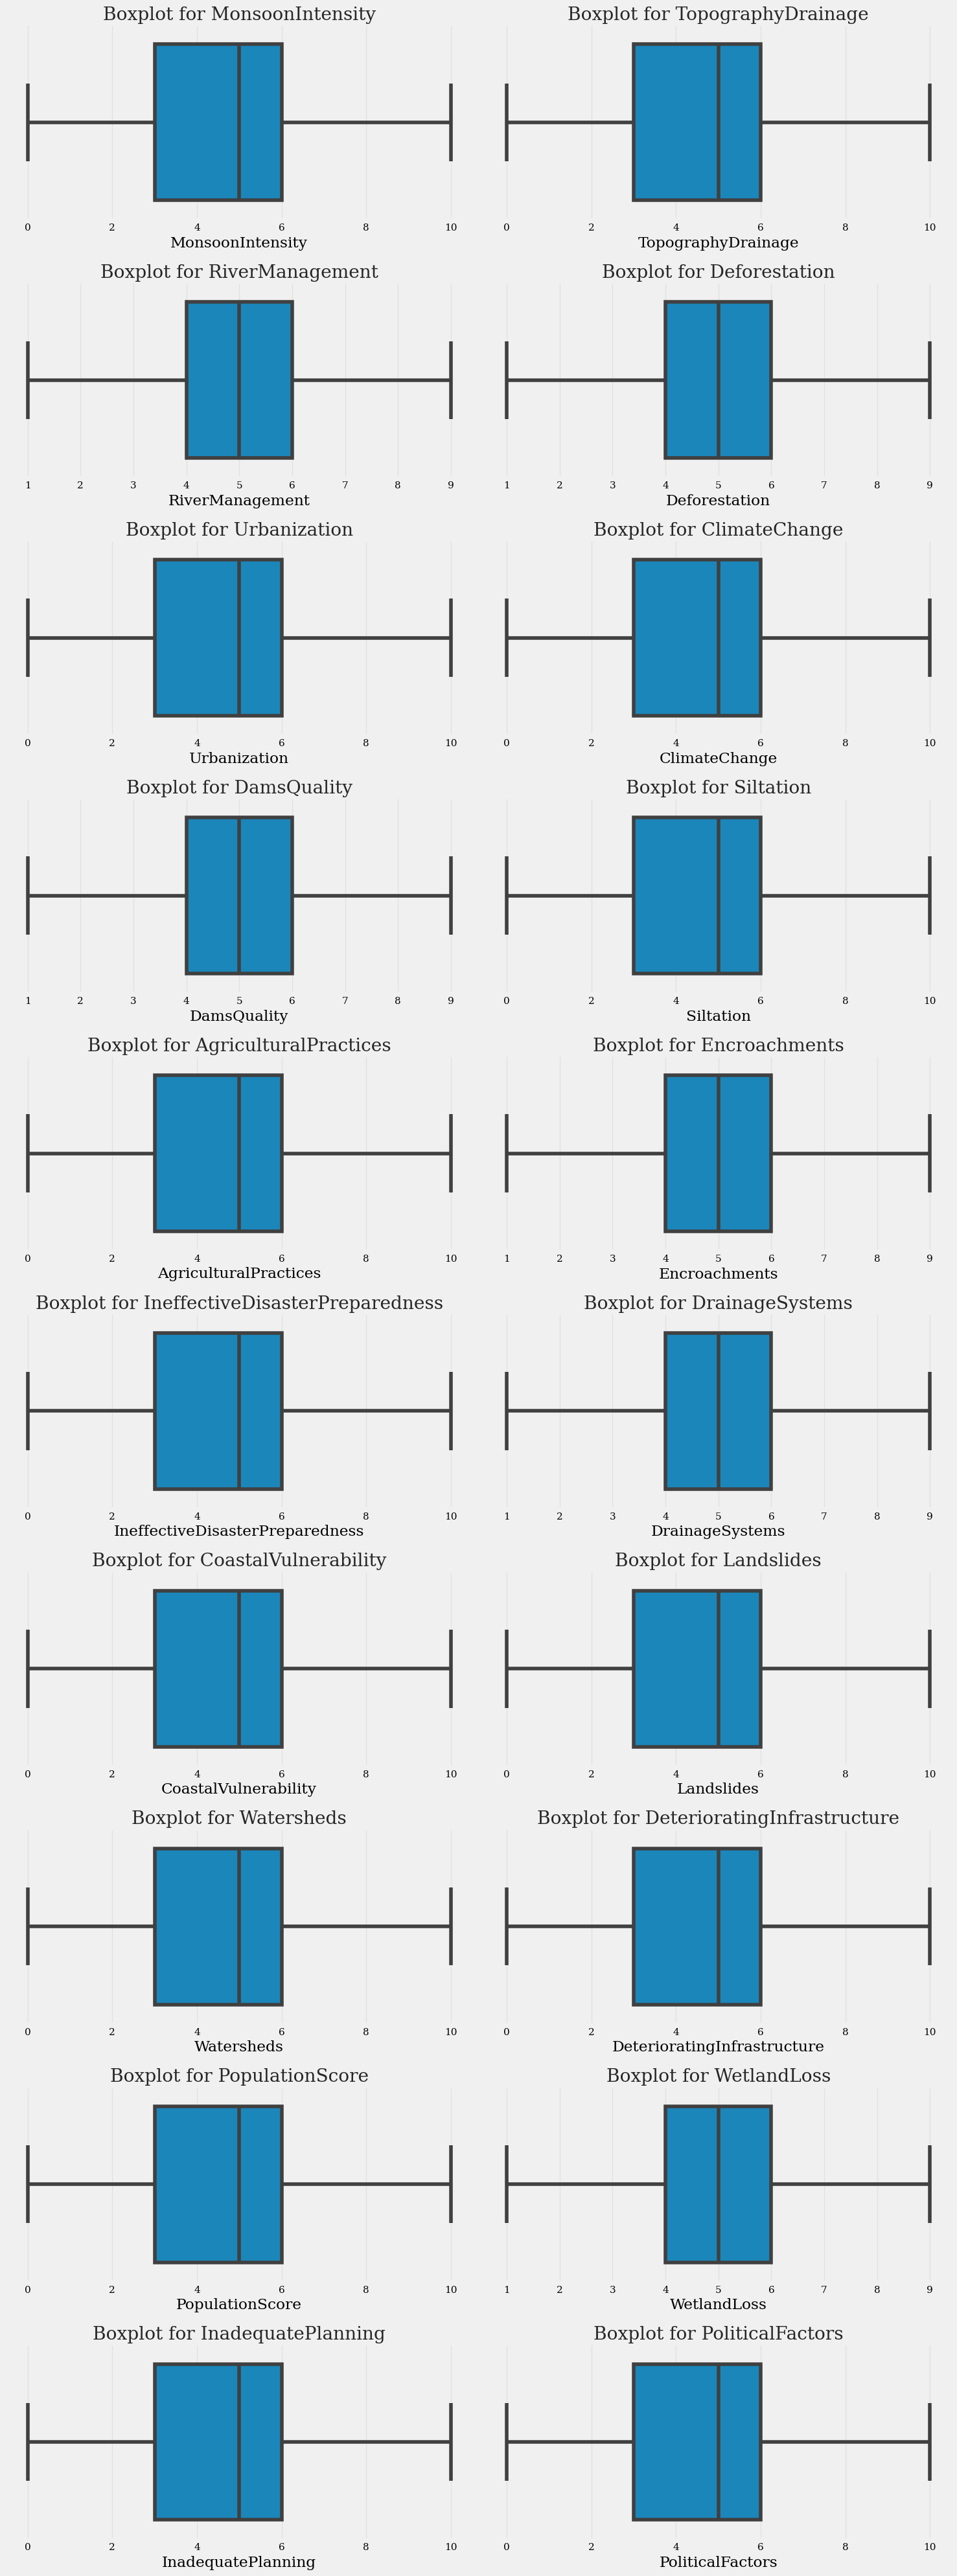

In [23]:
def plot_boxplots(data, columns, ncols=2):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))

    for i, column in enumerate(columns):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i % ncols]

        if data[column].dtype == 'O':  # 'O' represents object (categorical) dtype
            sns.countplot(x=column, data=data, ax=ax)
            ax.set_title(f'Countplot for {column}')
        else:
            sns.boxplot(x=column, data=data, ax=ax)
            ax.set_title(f'Boxplot for {column}')

    plt.tight_layout()
    plt.show()

plot_boxplots(train, continuous_vars)

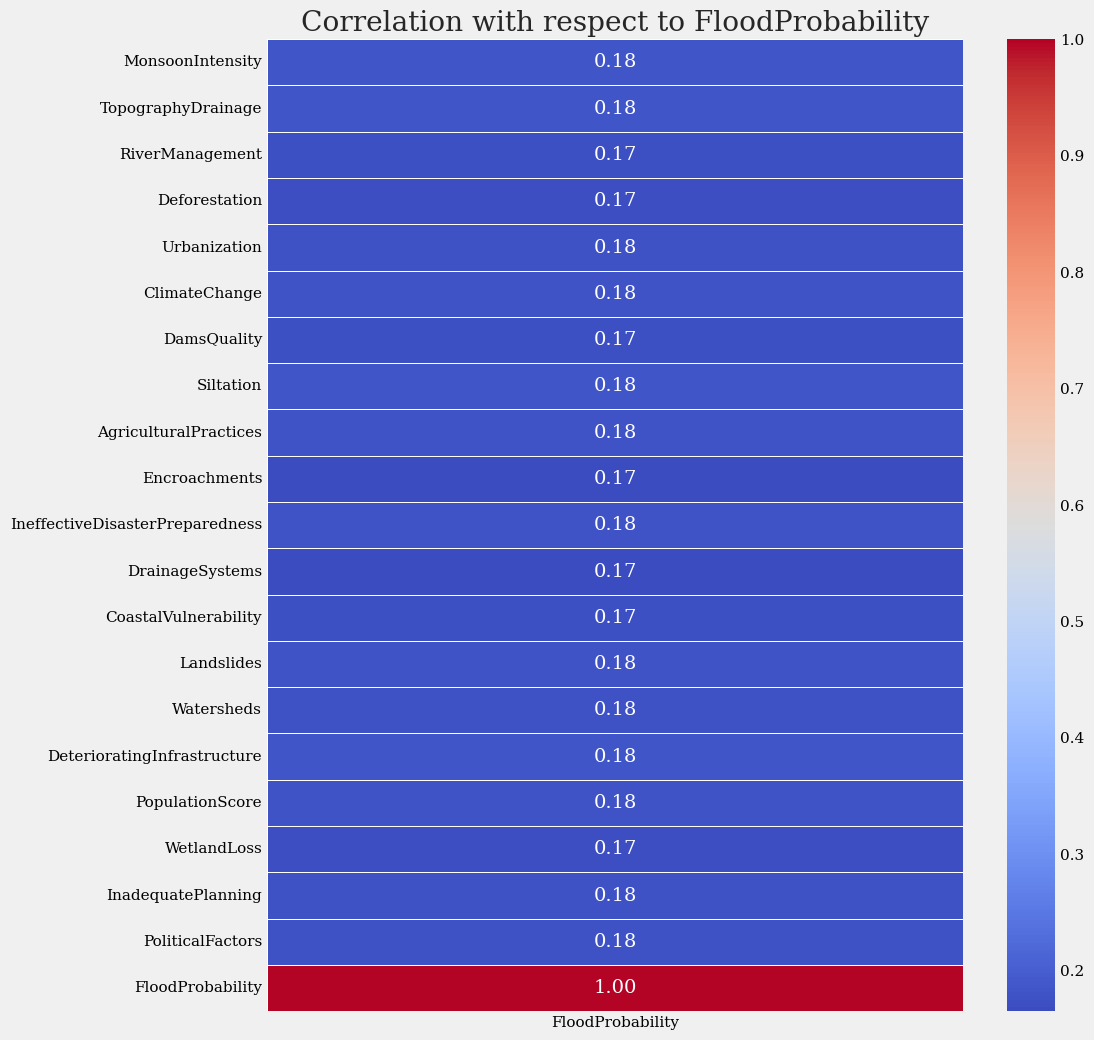

In [24]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix[['FloodProbability']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with respect to FloodProbability')
plt.show()